In [28]:
import numpy as np
import pandas as pd

import time

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.preprocessing import Normalizer, normalize, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import SGDClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from scikitplot import classifier_factory

import sys

sys.path.append('../')

# ANIMALS
INPUT_FILE = "./data/animals/label_scores.txt"
# PLANTS
# INPUT_FILE = "../../data/plants/label_scores.txt"

# Dictionary to use
FEATURES_FILE = './data/aaindex/aaindex_used.txt'

VERBOSE = True
CROSS_VAL = 5

RANDSEED = 7

# NAMES = [
#     "Nearest Neighbors",
#     # "Linear SVM 1"
#     # "Linear SVM 2",
#     # "RBF SVM",
#     "SGD",
#     # "Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     # "AdaBoost",
#     # "Naive Bayes",
#     # "QDA",
#     "LQA"
# ]

# CLASSIFIERS = [
#     KNeighborsClassifier(17), # ~49% acc
#     # LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, # fails to converge. takes long to run
#     #           multi_class='ovr', fit_intercept=True, intercept_scaling=1,
#     #           class_weight=None, verbose=VERBOSE, random_state=None, max_iter=1000),
#     # SVC(kernel="linear", C=0.025, verbose=VERBOSE), # ~47% acc, takes about 5 min to run on 20000 inputs
#     # SVC(gamma=2, C=1, verbose=VERBOSE), # takes too long on 20000 inputs
#     SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0,    # ~0.41 acc, 3 sec
#                   fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge',
#                   n_iter=5, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
#                   shuffle=True, verbose=VERBOSE, warm_start=False),
#     # GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),     # takes too long
#     DecisionTreeClassifier(max_depth=None),     # 0.41 acc, 20 sec
#     RandomForestClassifier(n_estimators=10, criterion='gini', max_features='auto',      # ~0.49 acc, 12 sec
#                            min_samples_split=2, verbose=VERBOSE),
#     MLPClassifier(alpha=1, verbose=VERBOSE),        # 0.48 acc, 29 sec
#     # AdaBoostClassifier(),       # 0.30 acc, 72 sec
#     # GaussianNB(),       # 0.09 acc, 1 sec
#     # QuadraticDiscriminantAnalysis(),     # 0.18 acc, 2 sec
#     LinearDiscriminantAnalysis()        # 0.46 acc, 2 sec
# ]

NAMES = [
    'Nearest Neighbors',
    'SGD',
    'Decision Tree',
    'Random Forest',
    'Neural Net',
    'LQA'
]

CLASSIFIERS = [
    KNeighborsClassifier(17),  # ~49% acc
    SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0,  # ~0.41 acc, 3 sec
                  fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='log',
                  n_iter=5, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
                  shuffle=True, verbose=VERBOSE, warm_start=False),
    DecisionTreeClassifier(max_depth=None),  # 0.41 acc, 20 sec
    RandomForestClassifier(n_estimators=10, criterion='gini', max_features='auto',  # ~0.49 acc, 12 sec
                           min_samples_split=2, verbose=VERBOSE),
    MLPClassifier(alpha=1, verbose=VERBOSE),  # 0.48 acc, 29 sec
    LinearDiscriminantAnalysis()  # 0.46 acc, 2 sec
]


def generate_tuple_lists(cla, tags):
    assert len(cla) == len(tags)
    return [(tags[i], cla[i]) for i in range(len(cla))]


def train_model():
    Y, X = read_preprocessed_data(INPUT_FILE, FEATURES_FILE, CROSS_VAL)

    x_len_before = len(X[0])
    # X = normalize(X, norm='l2', axis=1)
    # X = VarianceThreshold(threshold=0.00000005).fit_transform(X)
    # X = SelectKBest(f_classif, k=50).fit_transform(X, Y)
    X = StandardScaler().fit_transform(X)
    print('# features used: %d / %d' % (len(X[0]), x_len_before))

    # clf1 = LogisticRegression(random_state=1, verbose=VERBOSE)
    # clf2 = RandomForestClassifier(random_state=1, verbose=VERBOSE)
    # clf3 = GaussianNB()
    #
    # vc1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    #                          voting='hard')
    # scores = cross_val_score(vc1, X, Y, cv=CROSS_VAL)

    estimators = generate_tuple_lists(CLASSIFIERS, NAMES)
    vc = VotingClassifier(estimators, voting='hard')

    kfold = KFold(n_splits=CROSS_VAL, shuffle=True)

    start_time = time.time()
    scores = cross_val_score(vc, X, Y, cv=kfold, verbose=VERBOSE)
    end_time = time.time()

    print(scores)
    # The mean score and the 95% confidence interval

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    print("--- %s seconds ---" % (end_time - start_time))

    return vc

In [29]:
# Change the directory
chdir('/Users/juantorres/Developer/cs75/')

In [30]:
def read_preprocessed_data(input_file, features_file, exclude_labels_less_than=0, format='default'):
    """
    reads in label_scores.txt file and returns the labels and features as lists or dataframes
    :param input_file: directory of label_scores.txt file
    :param exclude_labels_less_than: skip labels with occurrence less than this value
    :param format default or df: what format to return the labels and features in
    :return: (labels, features)
    """
    with open(input_file, 'r') as ifile:
        lines = [line.rstrip().split('|') for line in ifile.readlines()]
    with open(features_file, 'r') as f:
        features_used = [line.strip() for line in f.readlines()]

    all_labels = [line[0] for line in lines]
    occurrences = Counter(all_labels)
    labeled_data = [(lines[i][0], map(float, lines[i][1:])) for i in range(len(lines)) if
                    occurrences[all_labels[i]] >= exclude_labels_less_than]
    labels, feature_matrix = zip(*labeled_data)

    if format == 'default':
        return list(labels), list(feature_matrix)  # tuples can make some things harder
    elif format == 'df':
        data = pd.DataFrame(data=list(feature_matrix), columns=features_used)
        labels = pd.DataFrame(data=list(labels))
        return labels, data
    else:
        raise Exception('Unknown format %s' % format)

In [31]:
clf = train_model()

# features used: 123 / 123


-- Epoch 1
Norm: 10.88, NNZs: 123, Bias: -2.619210, T: 80000, Avg. loss: 12.401334
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 6.05, NNZs: 123, Bias: -1.638881, T: 160000, Avg. loss: 7.408254
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 5.37, NNZs: 123, Bias: -1.524038, T: 240000, Avg. loss: 5.444442
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 4.45, NNZs: 123, Bias: -1.315175, T: 320000, Avg. loss: 4.374910
Total training time: 0.16 seconds.
-- Epoch 5


Norm: 4.45, NNZs: 123, Bias: -1.151334, T: 400000, Avg. loss: 3.690760
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 30.83, NNZs: 123, Bias: -223.799380, T: 80000, Avg. loss: 0.943188
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 30.39, NNZs: 123, Bias: -204.049566, T: 160000, Avg. loss: 0.727995
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 30.66, NNZs: 123, Bias: -192.520990, T: 240000, Avg. loss: 0.642759
Total training time: 0.18 seconds.
-- Epoch 4


Norm: 30.10, NNZs: 123, Bias: -184.446314, T: 320000, Avg. loss: 0.593519
Total training time: 0.24 seconds.
-- Epoch 5
Norm: 29.63, NNZs: 123, Bias: -178.237409, T: 400000, Avg. loss: 0.560143
Total training time: 0.29 seconds.
-- Epoch 1
Norm: 16.88, NNZs: 123, Bias: -12.784874, T: 80000, Avg. loss: 4.806445
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 9.19, NNZs: 123, Bias: -5.886191, T: 160000, Avg. loss: 2.628725
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 7.41, NNZs: 123, Bias: -5.929790, T: 240000, Avg. loss: 1.842093


Total training time: 0.14 seconds.
-- Epoch 4
Norm: 6.95, NNZs: 123, Bias: -5.679286, T: 320000, Avg. loss: 1.449406
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 6.16, NNZs: 123, Bias: -4.877536, T: 400000, Avg. loss: 1.221456
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 47.63, NNZs: 123, Bias: -313.154711, T: 80000, Avg. loss: 2.134301
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 43.75, NNZs: 123, Bias: -278.295291, T: 160000, Avg. loss: 1.714326
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 44.30, NNZs: 123, Bias: -258.137839, T: 240000, Avg. loss: 1.534068
Total training time: 0.15 seconds.
-- Epoch 4


Norm: 43.18, NNZs: 123, Bias: -243.878105, T: 320000, Avg. loss: 1.419696
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 42.45, NNZs: 123, Bias: -232.841182, T: 400000, Avg. loss: 1.340209
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 19.62, NNZs: 123, Bias: -22.291664, T: 80000, Avg. loss: 1.997889
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 6.60, NNZs: 123, Bias: -7.492448, T: 160000, Avg. loss: 1.106064
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 4.92, NNZs: 123, Bias: -6.003735, T: 240000, Avg. loss: 0.783249
Total training time: 0.15 seconds.
-- Epoch 4


Norm: 5.38, NNZs: 123, Bias: -7.879446, T: 320000, Avg. loss: 0.648536
Total training time: 0.22 seconds.
-- Epoch 5
Norm: 4.00, NNZs: 123, Bias: -5.477453, T: 400000, Avg. loss: 0.540486
Total training time: 0.31 seconds.
-- Epoch 1
Norm: 70.93, NNZs: 123, Bias: -430.362904, T: 80000, Avg. loss: 3.613743
Total training time: 0.09 seconds.
-- Epoch 2


Norm: 67.23, NNZs: 123, Bias: -391.088245, T: 160000, Avg. loss: 2.784471
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 61.60, NNZs: 123, Bias: -368.551089, T: 240000, Avg. loss: 2.458176
Total training time: 0.29 seconds.
-- Epoch 4
Norm: 59.57, NNZs: 123, Bias: -352.483895, T: 320000, Avg. loss: 2.268866
Total training time: 0.34 seconds.
-- Epoch 5
Norm: 58.46, NNZs: 123, Bias: -339.979200, T: 400000, Avg. loss: 2.142960
Total training time: 0.39 seconds.
-- Epoch 1


Norm: 23.57, NNZs: 123, Bias: -13.900289, T: 80000, Avg. loss: 8.558318
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 16.50, NNZs: 123, Bias: -7.056249, T: 160000, Avg. loss: 5.025515
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 11.65, NNZs: 123, Bias: -5.058481, T: 240000, Avg. loss: 3.575377
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 9.67, NNZs: 123, Bias: -5.260480, T: 320000, Avg. loss: 2.807763
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 8.98, NNZs: 123, Bias: -3.828538, T: 400000, Avg. loss: 2.381417
Total training time: 0.26 seconds.
-- Epoch 1


Norm: 19.06, NNZs: 123, Bias: -6.790261, T: 80000, Avg. loss: 3.309816
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 12.96, NNZs: 123, Bias: -4.629446, T: 160000, Avg. loss: 1.901663
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 11.14, NNZs: 123, Bias: -4.313538, T: 240000, Avg. loss: 1.403402
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 9.82, NNZs: 123, Bias: -3.964863, T: 320000, Avg. loss: 1.138356
Total training time: 0.23 seconds.
-- Epoch 5


Norm: 9.38, NNZs: 123, Bias: -3.598099, T: 400000, Avg. loss: 0.973837
Total training time: 0.33 seconds.
-- Epoch 1
Norm: 19.95, NNZs: 123, Bias: -5.330473, T: 80000, Avg. loss: 12.336358
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 13.03, NNZs: 123, Bias: -3.033380, T: 160000, Avg. loss: 6.925580
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 10.30, NNZs: 123, Bias: -2.829081, T: 240000, Avg. loss: 4.946850
Total training time: 0.20 seconds.
-- Epoch 4


Norm: 8.95, NNZs: 123, Bias: -2.902707, T: 320000, Avg. loss: 3.908041
Total training time: 0.29 seconds.
-- Epoch 5
Norm: 8.30, NNZs: 123, Bias: -2.484245, T: 400000, Avg. loss: 3.260897
Total training time: 0.37 seconds.
-- Epoch 1
Norm: 26.48, NNZs: 123, Bias: -273.051706, T: 80000, Avg. loss: 1.419345
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 24.81, NNZs: 123, Bias: -249.279971, T: 160000, Avg. loss: 1.131760
Total training time: 0.09 seconds.
-- Epoch 3


Norm: 24.55, NNZs: 123, Bias: -235.345423, T: 240000, Avg. loss: 1.017541
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 23.31, NNZs: 123, Bias: -225.604827, T: 320000, Avg. loss: 0.948919
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 23.45, NNZs: 123, Bias: -217.948564, T: 400000, Avg. loss: 0.901327
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 41.46, NNZs: 123, Bias: -397.239507, T: 80000, Avg. loss: 2.305208
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 42.38, NNZs: 123, Bias: -370.609768, T: 160000, Avg. loss: 1.847927


Total training time: 0.09 seconds.
-- Epoch 3
Norm: 42.90, NNZs: 123, Bias: -354.751189, T: 240000, Avg. loss: 1.673713
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 39.14, NNZs: 123, Bias: -343.843589, T: 320000, Avg. loss: 1.563145
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 38.06, NNZs: 123, Bias: -335.246382, T: 400000, Avg. loss: 1.490186
Total training time: 0.26 seconds.
-- Epoch 1


Norm: 17.16, NNZs: 123, Bias: -5.547506, T: 80000, Avg. loss: 7.586070
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 11.96, NNZs: 123, Bias: -4.941100, T: 160000, Avg. loss: 4.361762
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 9.71, NNZs: 123, Bias: -3.948853, T: 240000, Avg. loss: 3.150909
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 8.69, NNZs: 123, Bias: -3.161244, T: 320000, Avg. loss: 2.496590
Total training time: 0.22 seconds.
-- Epoch 5


Norm: 8.01, NNZs: 123, Bias: -3.531054, T: 400000, Avg. loss: 2.104670
Total training time: 0.29 seconds.
-- Epoch 1
Norm: 16.02, NNZs: 123, Bias: -325.415873, T: 80000, Avg. loss: 0.253965
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 15.57, NNZs: 123, Bias: -322.749601, T: 160000, Avg. loss: 0.180721
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 15.43, NNZs: 123, Bias: -321.133861, T: 240000, Avg. loss: 0.155538
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 15.36, NNZs: 123, Bias: -319.981502, T: 320000, Avg. loss: 0.142930
Total training time: 0.19 seconds.
-- Epoch 5


Norm: 15.33, NNZs: 123, Bias: -319.108300, T: 400000, Avg. loss: 0.135271
Total training time: 0.28 seconds.


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.8s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.3s finished


Iteration 1, loss = 1.73341777


Iteration 2, loss = 1.47016067


Iteration 3, loss = 1.39462847


Iteration 4, loss = 1.35915318


Iteration 5, loss = 1.33892671


Iteration 6, loss = 1.32658533


Iteration 7, loss = 1.31884241


Iteration 8, loss = 1.31288556


Iteration 9, loss = 1.30935132


Iteration 10, loss = 1.30791405


Iteration 11, loss = 1.30547550


Iteration 12, loss = 1.30260772


Iteration 13, loss = 1.30119652


Iteration 14, loss = 1.30226767


Iteration 15, loss = 1.29976527


Iteration 16, loss = 1.29953478


Iteration 17, loss = 1.29882955


Iteration 18, loss = 1.29755247


Iteration 19, loss = 1.29644582


Iteration 20, loss = 1.29706281


Iteration 21, loss = 1.29555047


Iteration 22, loss = 1.29392393


Iteration 23, loss = 1.29772003


Iteration 24, loss = 1.29590242


Iteration 25, loss = 1.29396104
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


/Users/juantorres/.virtualenvs/cs75/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


/Users/juantorres/.virtualenvs/cs75/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 12.76, NNZs: 123, Bias: -1.878056, T: 80000, Avg. loss: 11.800262
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 6.77, NNZs: 123, Bias: -2.199649, T: 160000, Avg. loss: 6.895797
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 5.40, NNZs: 123, Bias: -1.360751, T: 240000, Avg. loss: 5.110332
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 4.88, NNZs: 123, Bias: -1.234719, T: 320000, Avg. loss: 4.155551
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 4.42, NNZs: 123, Bias: -1.158772, T: 400000, Avg. loss: 3.540741
Total training time: 0.19 seconds.
-- Epoch 1


Norm: 36.10, NNZs: 123, Bias: -382.033006, T: 80000, Avg. loss: 1.502689
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 39.97, NNZs: 123, Bias: -361.559995, T: 160000, Avg. loss: 1.222214
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 40.61, NNZs: 123, Bias: -349.545508, T: 240000, Avg. loss: 1.108008
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 41.45, NNZs: 123, Bias: -341.025033, T: 320000, Avg. loss: 1.044573
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 40.41, NNZs: 123, Bias: -334.598228, T: 400000, Avg. loss: 1.001623


Total training time: 0.26 seconds.
-- Epoch 1
Norm: 17.89, NNZs: 123, Bias: -11.338948, T: 80000, Avg. loss: 3.984114
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 9.57, NNZs: 123, Bias: -7.017544, T: 160000, Avg. loss: 2.196425
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 7.72, NNZs: 123, Bias: -6.318145, T: 240000, Avg. loss: 1.558546
Total training time: 0.16 seconds.
-- Epoch 4


Norm: 6.96, NNZs: 123, Bias: -5.819472, T: 320000, Avg. loss: 1.225350
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 6.37, NNZs: 123, Bias: -5.551100, T: 400000, Avg. loss: 1.020335
Total training time: 0.27 seconds.
-- Epoch 1
Norm: 59.16, NNZs: 123, Bias: -492.611375, T: 80000, Avg. loss: 3.512898
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 59.26, NNZs: 123, Bias: -456.198593, T: 160000, Avg. loss: 2.854129
Total training time: 0.10 seconds.
-- Epoch 3


Norm: 57.92, NNZs: 123, Bias: -434.652743, T: 240000, Avg. loss: 2.588466
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 57.41, NNZs: 123, Bias: -419.444514, T: 320000, Avg. loss: 2.433390
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 56.71, NNZs: 123, Bias: -407.618184, T: 400000, Avg. loss: 2.326188
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 15.65, NNZs: 123, Bias: -18.158431, T: 80000, Avg. loss: 1.927255
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 6.36, NNZs: 123, Bias: -6.861133, T: 160000, Avg. loss: 1.064079
Total training time: 0.10 seconds.
-- Epoch 3


Norm: 4.89, NNZs: 123, Bias: -5.746060, T: 240000, Avg. loss: 0.756541
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 3.62, NNZs: 123, Bias: -5.708030, T: 320000, Avg. loss: 0.595138
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 3.52, NNZs: 123, Bias: -5.107364, T: 400000, Avg. loss: 0.496697
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 50.56, NNZs: 123, Bias: -244.622144, T: 80000, Avg. loss: 1.621582
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 42.85, NNZs: 123, Bias: -209.805043, T: 160000, Avg. loss: 1.321779
Total training time: 0.10 seconds.
-- Epoch 3


Norm: 39.90, NNZs: 123, Bias: -189.175927, T: 240000, Avg. loss: 1.177229
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 37.50, NNZs: 123, Bias: -174.742449, T: 320000, Avg. loss: 1.085939
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 36.34, NNZs: 123, Bias: -163.491185, T: 400000, Avg. loss: 1.018277
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 25.00, NNZs: 123, Bias: -12.794898, T: 80000, Avg. loss: 7.614185
Total training time: 0.05 seconds.
-- Epoch 2


Norm: 13.43, NNZs: 123, Bias: -6.879369, T: 160000, Avg. loss: 4.311330
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 11.92, NNZs: 123, Bias: -5.390992, T: 240000, Avg. loss: 3.128903
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 10.36, NNZs: 123, Bias: -4.732237, T: 320000, Avg. loss: 2.488301
Total training time: 0.22 seconds.
-- Epoch 5
Norm: 9.48, NNZs: 123, Bias: -4.602142, T: 400000, Avg. loss: 2.090759
Total training time: 0.27 seconds.
-- Epoch 1


Norm: 20.04, NNZs: 123, Bias: -7.172431, T: 80000, Avg. loss: 3.097712
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 13.25, NNZs: 123, Bias: -5.441135, T: 160000, Avg. loss: 1.788785
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 11.03, NNZs: 123, Bias: -4.814126, T: 240000, Avg. loss: 1.304391
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 10.14, NNZs: 123, Bias: -3.961939, T: 320000, Avg. loss: 1.054062
Total training time: 0.22 seconds.
-- Epoch 5


Norm: 9.55, NNZs: 123, Bias: -3.937808, T: 400000, Avg. loss: 0.899151
Total training time: 0.28 seconds.
-- Epoch 1
Norm: 20.49, NNZs: 123, Bias: -6.025237, T: 80000, Avg. loss: 13.929656
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 12.82, NNZs: 123, Bias: -3.207813, T: 160000, Avg. loss: 7.760595
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 9.96, NNZs: 123, Bias: -2.773225, T: 240000, Avg. loss: 5.513037
Total training time: 0.16 seconds.
-- Epoch 4


Norm: 8.92, NNZs: 123, Bias: -2.515426, T: 320000, Avg. loss: 4.383243
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 8.15, NNZs: 123, Bias: -2.679575, T: 400000, Avg. loss: 3.655124
Total training time: 0.27 seconds.
-- Epoch 1
Norm: 23.97, NNZs: 123, Bias: -229.339444, T: 80000, Avg. loss: 1.080691
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 21.40, NNZs: 123, Bias: -206.734544, T: 160000, Avg. loss: 0.899209
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 19.98, NNZs: 123, Bias: -193.157460, T: 240000, Avg. loss: 0.815662
Total training time: 0.14 seconds.
-- Epoch 4


Norm: 19.24, NNZs: 123, Bias: -183.781672, T: 320000, Avg. loss: 0.762022
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 18.57, NNZs: 123, Bias: -176.499299, T: 400000, Avg. loss: 0.724366
Total training time: 0.24 seconds.
-- Epoch 1
Norm: 37.47, NNZs: 123, Bias: -325.714163, T: 80000, Avg. loss: 1.663790
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 34.64, NNZs: 123, Bias: -300.397958, T: 160000, Avg. loss: 1.392227
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 34.16, NNZs: 123, Bias: -285.326845, T: 240000, Avg. loss: 1.267688
Total training time: 0.15 seconds.
-- Epoch 4


Norm: 32.15, NNZs: 123, Bias: -274.829847, T: 320000, Avg. loss: 1.191333
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 33.67, NNZs: 123, Bias: -266.398144, T: 400000, Avg. loss: 1.143544
Total training time: 0.24 seconds.
-- Epoch 1
Norm: 17.37, NNZs: 123, Bias: -8.128545, T: 80000, Avg. loss: 6.186463
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 11.66, NNZs: 123, Bias: -3.949621, T: 160000, Avg. loss: 3.569195
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 9.52, NNZs: 123, Bias: -3.517691, T: 240000, Avg. loss: 2.631156
Total training time: 0.13 seconds.
-- Epoch 4


Norm: 8.95, NNZs: 123, Bias: -3.174789, T: 320000, Avg. loss: 2.129766
Total training time: 0.18 seconds.
-- Epoch 5
Norm: 8.21, NNZs: 123, Bias: -2.997457, T: 400000, Avg. loss: 1.804797
Total training time: 0.23 seconds.
-- Epoch 1
Norm: 13.76, NNZs: 123, Bias: -215.854907, T: 80000, Avg. loss: 0.138376
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 14.47, NNZs: 123, Bias: -213.308020, T: 160000, Avg. loss: 0.098975
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 14.71, NNZs: 123, Bias: -211.786767, T: 240000, Avg. loss: 0.085193
Total training time: 0.11 seconds.
-- Epoch 4


Norm: 14.83, NNZs: 123, Bias: -210.716524, T: 320000, Avg. loss: 0.078116
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 14.91, NNZs: 123, Bias: -209.868504, T: 400000, Avg. loss: 0.073757
Total training time: 0.21 seconds.


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished


Iteration 1, loss = 1.73762735


Iteration 2, loss = 1.46563885


Iteration 3, loss = 1.38683092


Iteration 4, loss = 1.34858256


Iteration 5, loss = 1.32807939


Iteration 6, loss = 1.31688612


Iteration 7, loss = 1.31038515


Iteration 8, loss = 1.30419191


Iteration 9, loss = 1.30339328


Iteration 10, loss = 1.29951027


Iteration 11, loss = 1.29866138


Iteration 12, loss = 1.29802211


Iteration 13, loss = 1.29547882


Iteration 14, loss = 1.29528658


Iteration 15, loss = 1.29576121


Iteration 16, loss = 1.29414523


Iteration 17, loss = 1.29261493


Iteration 18, loss = 1.29170728


Iteration 19, loss = 1.29165152


Iteration 20, loss = 1.29076432


Iteration 21, loss = 1.29165529


Iteration 22, loss = 1.29300953


Iteration 23, loss = 1.28822928


Iteration 24, loss = 1.29261527


Iteration 25, loss = 1.28822980


Iteration 26, loss = 1.28804944


Iteration 27, loss = 1.28825879


Iteration 28, loss = 1.28768556


Iteration 29, loss = 1.28797313


Iteration 30, loss = 1.28744640


Iteration 31, loss = 1.28867612


Iteration 32, loss = 1.28663845


Iteration 33, loss = 1.28871951


Iteration 34, loss = 1.28696825


Iteration 35, loss = 1.28635646


Iteration 36, loss = 1.28598250


Iteration 37, loss = 1.28662162


Iteration 38, loss = 1.28499448


Iteration 39, loss = 1.28693449


Iteration 40, loss = 1.28616084


Iteration 41, loss = 1.28612616
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 9.52, NNZs: 123, Bias: -1.318350, T: 80000, Avg. loss: 12.353453
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 7.05, NNZs: 123, Bias: -2.076108, T: 160000, Avg. loss: 7.258352
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 5.49, NNZs: 123, Bias: -1.329612, T: 240000, Avg. loss: 5.337520
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 4.77, NNZs: 123, Bias: -1.375204, T: 320000, Avg. loss: 4.278769
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 4.22, NNZs: 123, Bias: -1.160633, T: 400000, Avg. loss: 3.610947


Total training time: 0.20 seconds.
-- Epoch 1
Norm: 30.80, NNZs: 123, Bias: -195.626755, T: 80000, Avg. loss: 0.896400
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 29.29, NNZs: 123, Bias: -176.294178, T: 160000, Avg. loss: 0.672094
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 29.17, NNZs: 123, Bias: -164.674864, T: 240000, Avg. loss: 0.582946
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 28.66, NNZs: 123, Bias: -156.615655, T: 320000, Avg. loss: 0.531949
Total training time: 0.19 seconds.
-- Epoch 5


Norm: 28.52, NNZs: 123, Bias: -150.287811, T: 400000, Avg. loss: 0.497380
Total training time: 0.24 seconds.
-- Epoch 1
Norm: 14.73, NNZs: 123, Bias: -12.069167, T: 80000, Avg. loss: 3.201794
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 9.42, NNZs: 123, Bias: -6.251525, T: 160000, Avg. loss: 1.802316
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 8.63, NNZs: 123, Bias: -8.382668, T: 240000, Avg. loss: 1.306452
Total training time: 0.15 seconds.
-- Epoch 4


Norm: 7.31, NNZs: 123, Bias: -5.667027, T: 320000, Avg. loss: 1.039119
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 6.88, NNZs: 123, Bias: -4.838709, T: 400000, Avg. loss: 0.892749
Total training time: 0.27 seconds.
-- Epoch 1
Norm: 44.88, NNZs: 123, Bias: -247.426346, T: 80000, Avg. loss: 1.760438
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 43.47, NNZs: 123, Bias: -212.664439, T: 160000, Avg. loss: 1.377228
Total training time: 0.10 seconds.
-- Epoch 3


Norm: 41.29, NNZs: 123, Bias: -192.649114, T: 240000, Avg. loss: 1.201985
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 39.38, NNZs: 123, Bias: -178.766620, T: 320000, Avg. loss: 1.093817
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 38.48, NNZs: 123, Bias: -167.917995, T: 400000, Avg. loss: 1.018436
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 14.31, NNZs: 123, Bias: -16.173493, T: 80000, Avg. loss: 2.341739
Total training time: 0.05 seconds.
-- Epoch 2


Norm: 5.16, NNZs: 123, Bias: -6.771157, T: 160000, Avg. loss: 1.268328
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 5.63, NNZs: 123, Bias: -5.820280, T: 240000, Avg. loss: 0.912675
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 4.09, NNZs: 123, Bias: -5.284416, T: 320000, Avg. loss: 0.717014
Total training time: 0.22 seconds.
-- Epoch 5
Norm: 3.90, NNZs: 123, Bias: -5.257961, T: 400000, Avg. loss: 0.597018
Total training time: 0.27 seconds.
-- Epoch 1


Norm: 46.20, NNZs: 123, Bias: -250.868305, T: 80000, Avg. loss: 1.801588
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 43.92, NNZs: 123, Bias: -215.118861, T: 160000, Avg. loss: 1.431888
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 41.32, NNZs: 123, Bias: -194.048473, T: 240000, Avg. loss: 1.266672
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 38.65, NNZs: 123, Bias: -179.450603, T: 320000, Avg. loss: 1.158623
Total training time: 0.21 seconds.
-- Epoch 5


Norm: 37.30, NNZs: 123, Bias: -168.004046, T: 400000, Avg. loss: 1.082915
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 22.12, NNZs: 123, Bias: -12.225144, T: 80000, Avg. loss: 8.553898
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 15.13, NNZs: 123, Bias: -7.485139, T: 160000, Avg. loss: 4.948742
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 11.38, NNZs: 123, Bias: -5.844702, T: 240000, Avg. loss: 3.574165
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 10.07, NNZs: 123, Bias: -4.523409, T: 320000, Avg. loss: 2.808173
Total training time: 0.20 seconds.
-- Epoch 5


Norm: 9.04, NNZs: 123, Bias: -4.161153, T: 400000, Avg. loss: 2.331151
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 19.49, NNZs: 123, Bias: -7.650425, T: 80000, Avg. loss: 4.794252
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 13.56, NNZs: 123, Bias: -8.131533, T: 160000, Avg. loss: 2.652521
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 10.84, NNZs: 123, Bias: -3.836223, T: 240000, Avg. loss: 1.886068
Total training time: 0.16 seconds.
-- Epoch 4


Norm: 9.77, NNZs: 123, Bias: -3.737429, T: 320000, Avg. loss: 1.492564
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 9.28, NNZs: 123, Bias: -3.537932, T: 400000, Avg. loss: 1.249320
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 19.66, NNZs: 123, Bias: -6.145383, T: 80000, Avg. loss: 10.344498
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 13.05, NNZs: 123, Bias: -3.963869, T: 160000, Avg. loss: 6.126022
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 10.77, NNZs: 123, Bias: -2.824864, T: 240000, Avg. loss: 4.430511
Total training time: 0.15 seconds.
-- Epoch 4


Norm: 9.20, NNZs: 123, Bias: -2.444581, T: 320000, Avg. loss: 3.523806
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 8.22, NNZs: 123, Bias: -2.239007, T: 400000, Avg. loss: 2.952631
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 26.22, NNZs: 123, Bias: -512.694943, T: 80000, Avg. loss: 2.941455
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 25.81, NNZs: 123, Bias: -489.488268, T: 160000, Avg. loss: 2.304156
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 25.63, NNZs: 123, Bias: -475.874082, T: 240000, Avg. loss: 2.066852


Total training time: 0.15 seconds.
-- Epoch 4
Norm: 25.76, NNZs: 123, Bias: -466.157099, T: 320000, Avg. loss: 1.937722
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 25.67, NNZs: 123, Bias: -458.640243, T: 400000, Avg. loss: 1.852780
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 38.21, NNZs: 123, Bias: -336.406743, T: 80000, Avg. loss: 2.310301
Total training time: 0.06 seconds.
-- Epoch 2


Norm: 34.18, NNZs: 123, Bias: -310.063047, T: 160000, Avg. loss: 1.759528
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 31.67, NNZs: 123, Bias: -294.706398, T: 240000, Avg. loss: 1.546393
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 31.22, NNZs: 123, Bias: -283.527555, T: 320000, Avg. loss: 1.426015
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 30.45, NNZs: 123, Bias: -274.985097, T: 400000, Avg. loss: 1.344121
Total training time: 0.26 seconds.
-- Epoch 1


Norm: 17.40, NNZs: 123, Bias: -6.529608, T: 80000, Avg. loss: 5.936026
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 11.74, NNZs: 123, Bias: -5.601936, T: 160000, Avg. loss: 3.446485
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 9.18, NNZs: 123, Bias: -2.948422, T: 240000, Avg. loss: 2.505902
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 8.39, NNZs: 123, Bias: -3.356450, T: 320000, Avg. loss: 2.027554
Total training time: 0.22 seconds.
-- Epoch 5


Norm: 8.05, NNZs: 123, Bias: -3.214054, T: 400000, Avg. loss: 1.721473
Total training time: 0.28 seconds.
-- Epoch 1
Norm: 13.55, NNZs: 123, Bias: -548.049281, T: 80000, Avg. loss: 0.795205
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 14.28, NNZs: 123, Bias: -545.315319, T: 160000, Avg. loss: 0.496910
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 14.53, NNZs: 123, Bias: -543.686592, T: 240000, Avg. loss: 0.396317
Total training time: 0.17 seconds.
-- Epoch 4


Norm: 14.66, NNZs: 123, Bias: -542.542097, T: 320000, Avg. loss: 0.346211
Total training time: 0.23 seconds.
-- Epoch 5
Norm: 14.73, NNZs: 123, Bias: -541.636856, T: 400000, Avg. loss: 0.315846
Total training time: 0.28 seconds.


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.4s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.0s finished


Iteration 1, loss = 1.71020458


Iteration 2, loss = 1.46762804


Iteration 3, loss = 1.39270954


Iteration 4, loss = 1.35620154


Iteration 5, loss = 1.33806185


Iteration 6, loss = 1.32591790


Iteration 7, loss = 1.31807839


Iteration 8, loss = 1.31530638


Iteration 9, loss = 1.31113548


Iteration 10, loss = 1.30736294


Iteration 11, loss = 1.30577512


Iteration 12, loss = 1.30555028


Iteration 13, loss = 1.30488647


Iteration 14, loss = 1.30306209


Iteration 15, loss = 1.30256406


Iteration 16, loss = 1.29988268


Iteration 17, loss = 1.30003621


Iteration 18, loss = 1.30095946


Iteration 19, loss = 1.29956351


Iteration 20, loss = 1.29996507


Iteration 21, loss = 1.29684241


Iteration 22, loss = 1.29800270


Iteration 23, loss = 1.29991142


Iteration 24, loss = 1.29693056
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 10.55, NNZs: 123, Bias: -1.776476, T: 80000, Avg. loss: 16.383303
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 7.41, NNZs: 123, Bias: -1.638925, T: 160000, Avg. loss: 9.350511
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 5.44, NNZs: 123, Bias: -1.306563, T: 240000, Avg. loss: 6.735926
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 4.85, NNZs: 123, Bias: -1.286761, T: 320000, Avg. loss: 5.337839
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 4.41, NNZs: 123, Bias: -1.134436, T: 400000, Avg. loss: 4.471600


Total training time: 0.20 seconds.
-- Epoch 1
Norm: 47.18, NNZs: 123, Bias: -442.331084, T: 80000, Avg. loss: 1.751496
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 48.53, NNZs: 123, Bias: -420.818861, T: 160000, Avg. loss: 1.435961
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 48.73, NNZs: 123, Bias: -408.252759, T: 240000, Avg. loss: 1.314708
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 47.64, NNZs: 123, Bias: -399.411995, T: 320000, Avg. loss: 1.245534
Total training time: 0.19 seconds.
-- Epoch 5


Norm: 46.65, NNZs: 123, Bias: -392.586506, T: 400000, Avg. loss: 1.199976
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 15.19, NNZs: 123, Bias: -13.085369, T: 80000, Avg. loss: 2.665767
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 9.17, NNZs: 123, Bias: -6.052311, T: 160000, Avg. loss: 1.531540
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 7.23, NNZs: 123, Bias: -5.369416, T: 240000, Avg. loss: 1.106882
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 7.04, NNZs: 123, Bias: -5.680706, T: 320000, Avg. loss: 0.903489
Total training time: 0.18 seconds.
-- Epoch 5


Norm: 6.28, NNZs: 123, Bias: -5.133294, T: 400000, Avg. loss: 0.763548
Total training time: 0.23 seconds.
-- Epoch 1
Norm: 45.94, NNZs: 123, Bias: -281.321798, T: 80000, Avg. loss: 1.860017
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 45.61, NNZs: 123, Bias: -246.451864, T: 160000, Avg. loss: 1.506872
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 43.81, NNZs: 123, Bias: -225.933856, T: 240000, Avg. loss: 1.343661
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 43.77, NNZs: 123, Bias: -211.279543, T: 320000, Avg. loss: 1.240746
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 42.70, NNZs: 123, Bias: -200.172742, T: 400000, Avg. loss: 1.166317
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 20.70, NNZs: 123, Bias: -24.007913, T: 80000, Avg. loss: 2.115929
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 7.29, NNZs: 123, Bias: -8.727329, T: 160000, Avg. loss: 1.170274
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 5.46, NNZs: 123, Bias: -6.491018, T: 240000, Avg. loss: 0.843043
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 4.38, NNZs: 123, Bias: -5.973126, T: 320000, Avg. loss: 0.659480
Total training time: 0.18 seconds.
-- Epoch 5


Norm: 4.01, NNZs: 123, Bias: -5.190012, T: 400000, Avg. loss: 0.548240
Total training time: 0.22 seconds.
-- Epoch 1
Norm: 41.04, NNZs: 123, Bias: -214.600378, T: 80000, Avg. loss: 1.565279
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 36.80, NNZs: 123, Bias: -178.661762, T: 160000, Avg. loss: 1.229623
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 35.33, NNZs: 123, Bias: -158.301042, T: 240000, Avg. loss: 1.073538
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 32.52, NNZs: 123, Bias: -144.121963, T: 320000, Avg. loss: 0.973762
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 31.89, NNZs: 123, Bias: -132.888362, T: 400000, Avg. loss: 0.902068
Total training time: 0.22 seconds.
-- Epoch 1
Norm: 23.33, NNZs: 123, Bias: -12.146798, T: 80000, Avg. loss: 8.515986
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 13.61, NNZs: 123, Bias: -6.568351, T: 160000, Avg. loss: 4.954910
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 11.72, NNZs: 123, Bias: -6.564019, T: 240000, Avg. loss: 3.579971
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 9.84, NNZs: 123, Bias: -5.184538, T: 320000, Avg. loss: 2.855507
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 9.13, NNZs: 123, Bias: -4.629925, T: 400000, Avg. loss: 2.372713
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 18.16, NNZs: 123, Bias: -8.912743, T: 80000, Avg. loss: 12.645671
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 12.57, NNZs: 123, Bias: -4.809796, T: 160000, Avg. loss: 6.546705
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 10.52, NNZs: 123, Bias: -4.076869, T: 240000, Avg. loss: 4.473755
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 9.75, NNZs: 123, Bias: -3.882779, T: 320000, Avg. loss: 3.429048
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 9.37, NNZs: 123, Bias: -3.876336, T: 400000, Avg. loss: 2.799915
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 16.94, NNZs: 123, Bias: -4.316088, T: 80000, Avg. loss: 9.310191
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 12.59, NNZs: 123, Bias: -4.079271, T: 160000, Avg. loss: 5.557612
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 10.35, NNZs: 123, Bias: -2.342231, T: 240000, Avg. loss: 4.119300
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 8.71, NNZs: 123, Bias: -2.408486, T: 320000, Avg. loss: 3.281931
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 8.02, NNZs: 123, Bias: -2.213630, T: 400000, Avg. loss: 2.761774
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 23.19, NNZs: 123, Bias: -425.813101, T: 80000, Avg. loss: 2.092803
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 25.66, NNZs: 123, Bias: -401.540315, T: 160000, Avg. loss: 1.760490
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 25.48, NNZs: 123, Bias: -387.218170, T: 240000, Avg. loss: 1.622160
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 24.58, NNZs: 123, Bias: -377.131920, T: 320000, Avg. loss: 1.542507
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 24.43, NNZs: 123, Bias: -369.213612, T: 400000, Avg. loss: 1.487996
Total training time: 0.20 seconds.
-- Epoch 1
Norm: 42.09, NNZs: 123, Bias: -374.413361, T: 80000, Avg. loss: 2.469290
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 39.20, NNZs: 123, Bias: -348.178999, T: 160000, Avg. loss: 1.886746
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 36.66, NNZs: 123, Bias: -332.775468, T: 240000, Avg. loss: 1.663609
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 36.24, NNZs: 123, Bias: -321.726707, T: 320000, Avg. loss: 1.538740
Total training time: 0.16 seconds.
-- Epoch 5


Norm: 37.10, NNZs: 123, Bias: -313.058610, T: 400000, Avg. loss: 1.459409
Total training time: 0.20 seconds.
-- Epoch 1
Norm: 16.13, NNZs: 123, Bias: -5.445184, T: 80000, Avg. loss: 6.379134
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 10.63, NNZs: 123, Bias: -3.522802, T: 160000, Avg. loss: 3.649537
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 8.91, NNZs: 123, Bias: -3.484833, T: 240000, Avg. loss: 2.657991
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 8.46, NNZs: 123, Bias: -3.390071, T: 320000, Avg. loss: 2.138333
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 8.12, NNZs: 123, Bias: -2.833610, T: 400000, Avg. loss: 1.834868
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 14.32, NNZs: 123, Bias: -431.298009, T: 80000, Avg. loss: 0.465155
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 14.74, NNZs: 123, Bias: -428.668616, T: 160000, Avg. loss: 0.305046
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 14.89, NNZs: 123, Bias: -427.047700, T: 240000, Avg. loss: 0.250992
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 14.96, NNZs: 123, Bias: -425.948850, T: 320000, Avg. loss: 0.223917
Total training time: 0.19 seconds.
-- Epoch 5


Norm: 15.01, NNZs: 123, Bias: -425.079999, T: 400000, Avg. loss: 0.207593
Total training time: 0.24 seconds.


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.8s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.5s finished


Iteration 1, loss = 1.74637990


Iteration 2, loss = 1.47612607


Iteration 3, loss = 1.39555458


Iteration 4, loss = 1.35765140


Iteration 5, loss = 1.33567399


Iteration 6, loss = 1.32504944


Iteration 7, loss = 1.31654045


Iteration 8, loss = 1.31170228


Iteration 9, loss = 1.30867075


Iteration 10, loss = 1.30577249


Iteration 11, loss = 1.30403129


Iteration 12, loss = 1.30497043


Iteration 13, loss = 1.29929410


Iteration 14, loss = 1.29945099


Iteration 15, loss = 1.29825681


Iteration 16, loss = 1.29755431


Iteration 17, loss = 1.29849960


Iteration 18, loss = 1.29623545


Iteration 19, loss = 1.29691581


Iteration 20, loss = 1.29496503


Iteration 21, loss = 1.29455325


Iteration 22, loss = 1.29515758


Iteration 23, loss = 1.29289098


Iteration 24, loss = 1.29227331


Iteration 25, loss = 1.29284057


Iteration 26, loss = 1.29373048


Iteration 27, loss = 1.29269801
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 9.69, NNZs: 123, Bias: -3.210082, T: 80000, Avg. loss: 17.300817
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 6.91, NNZs: 123, Bias: -1.079104, T: 160000, Avg. loss: 9.709738
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 4.73, NNZs: 123, Bias: -1.462368, T: 240000, Avg. loss: 6.988393
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 5.17, NNZs: 123, Bias: -1.231958, T: 320000, Avg. loss: 5.535586
Total training time: 0.17 seconds.
-- Epoch 5


Norm: 4.53, NNZs: 123, Bias: -1.156453, T: 400000, Avg. loss: 4.603713
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 38.29, NNZs: 123, Bias: -354.702147, T: 80000, Avg. loss: 1.305441
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 39.71, NNZs: 123, Bias: -334.759389, T: 160000, Avg. loss: 1.071334
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 39.80, NNZs: 123, Bias: -323.203022, T: 240000, Avg. loss: 0.977866
Total training time: 0.16 seconds.
-- Epoch 4


Norm: 39.10, NNZs: 123, Bias: -315.105660, T: 320000, Avg. loss: 0.924486
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 38.51, NNZs: 123, Bias: -308.772230, T: 400000, Avg. loss: 0.888742
Total training time: 0.27 seconds.
-- Epoch 1
Norm: 15.79, NNZs: 123, Bias: -11.314797, T: 80000, Avg. loss: 2.659112
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 9.65, NNZs: 123, Bias: -6.364090, T: 160000, Avg. loss: 1.524798
Total training time: 0.10 seconds.
-- Epoch 3


Norm: 7.74, NNZs: 123, Bias: -6.621796, T: 240000, Avg. loss: 1.169445
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 6.81, NNZs: 123, Bias: -5.605472, T: 320000, Avg. loss: 0.962806
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 6.56, NNZs: 123, Bias: -5.079192, T: 400000, Avg. loss: 0.811196
Total training time: 0.26 seconds.
-- Epoch 1
Norm: 30.80, NNZs: 123, Bias: -149.561158, T: 80000, Avg. loss: 1.171017
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 29.41, NNZs: 123, Bias: -117.977379, T: 160000, Avg. loss: 0.855159


Total training time: 0.09 seconds.
-- Epoch 3
Norm: 25.76, NNZs: 123, Bias: -100.777115, T: 240000, Avg. loss: 0.710115
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 24.10, NNZs: 123, Bias: -88.388737, T: 320000, Avg. loss: 0.623953
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 22.67, NNZs: 123, Bias: -79.029948, T: 400000, Avg. loss: 0.563624
Total training time: 0.24 seconds.
-- Epoch 1
Norm: 14.28, NNZs: 123, Bias: -17.698729, T: 80000, Avg. loss: 2.037415
Total training time: 0.04 seconds.
-- Epoch 2


Norm: 6.65, NNZs: 123, Bias: -7.858221, T: 160000, Avg. loss: 1.115301
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 4.64, NNZs: 123, Bias: -6.380817, T: 240000, Avg. loss: 0.796627
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 3.97, NNZs: 123, Bias: -5.855444, T: 320000, Avg. loss: 0.625959
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 3.56, NNZs: 123, Bias: -5.111109, T: 400000, Avg. loss: 0.520354
Total training time: 0.24 seconds.
-- Epoch 1
Norm: 32.14, NNZs: 123, Bias: -138.196478, T: 80000, Avg. loss: 1.143522
Total training time: 0.05 seconds.
-- Epoch 2


Norm: 26.19, NNZs: 123, Bias: -104.608527, T: 160000, Avg. loss: 0.852942
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 24.18, NNZs: 123, Bias: -85.174208, T: 240000, Avg. loss: 0.714481
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 21.83, NNZs: 123, Bias: -71.600516, T: 320000, Avg. loss: 0.622531
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 19.87, NNZs: 123, Bias: -61.477685, T: 400000, Avg. loss: 0.556225
Total training time: 0.25 seconds.
-- Epoch 1
Norm: 22.39, NNZs: 123, Bias: -12.810268, T: 80000, Avg. loss: 6.995639
Total training time: 0.05 seconds.
-- Epoch 2


Norm: 14.46, NNZs: 123, Bias: -6.522773, T: 160000, Avg. loss: 4.103941
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 12.18, NNZs: 123, Bias: -5.183085, T: 240000, Avg. loss: 3.112688
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 10.18, NNZs: 123, Bias: -4.928392, T: 320000, Avg. loss: 2.459876
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 9.58, NNZs: 123, Bias: -4.257697, T: 400000, Avg. loss: 2.077982
Total training time: 0.26 seconds.
-- Epoch 1


Norm: 19.06, NNZs: 123, Bias: -6.508758, T: 80000, Avg. loss: 4.135888
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 13.38, NNZs: 123, Bias: -8.175248, T: 160000, Avg. loss: 2.355422
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 10.61, NNZs: 123, Bias: -4.780002, T: 240000, Avg. loss: 1.681913
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 9.75, NNZs: 123, Bias: -4.148846, T: 320000, Avg. loss: 1.349292
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 9.08, NNZs: 123, Bias: -3.657824, T: 400000, Avg. loss: 1.133510
Total training time: 0.23 seconds.
-- Epoch 1


Norm: 22.22, NNZs: 123, Bias: -6.476177, T: 80000, Avg. loss: 10.389037
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 13.33, NNZs: 123, Bias: -4.409072, T: 160000, Avg. loss: 6.125665
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 10.12, NNZs: 123, Bias: -2.574327, T: 240000, Avg. loss: 4.485226
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 9.49, NNZs: 123, Bias: -2.874487, T: 320000, Avg. loss: 3.574217
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 8.51, NNZs: 123, Bias: -2.440445, T: 400000, Avg. loss: 3.013971
Total training time: 0.24 seconds.
-- Epoch 1


Norm: 27.42, NNZs: 123, Bias: -279.348031, T: 80000, Avg. loss: 1.424249
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 27.03, NNZs: 123, Bias: -255.365110, T: 160000, Avg. loss: 1.159860
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 25.69, NNZs: 123, Bias: -241.107730, T: 240000, Avg. loss: 1.046975
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 24.43, NNZs: 123, Bias: -231.250239, T: 320000, Avg. loss: 0.978518
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 24.73, NNZs: 123, Bias: -223.500550, T: 400000, Avg. loss: 0.930040
Total training time: 0.23 seconds.
-- Epoch 1


Norm: 38.67, NNZs: 123, Bias: -286.530206, T: 80000, Avg. loss: 1.666621
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 34.64, NNZs: 123, Bias: -262.651207, T: 160000, Avg. loss: 1.288085
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 32.81, NNZs: 123, Bias: -248.802730, T: 240000, Avg. loss: 1.154724
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 29.78, NNZs: 123, Bias: -239.148754, T: 320000, Avg. loss: 1.063249
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 30.77, NNZs: 123, Bias: -231.344270, T: 400000, Avg. loss: 1.007099
Total training time: 0.21 seconds.
-- Epoch 1


Norm: 19.51, NNZs: 123, Bias: -6.441707, T: 80000, Avg. loss: 5.568671
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 11.28, NNZs: 123, Bias: -3.573939, T: 160000, Avg. loss: 3.332737
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 9.48, NNZs: 123, Bias: -3.376409, T: 240000, Avg. loss: 2.465218
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 8.56, NNZs: 123, Bias: -2.990779, T: 320000, Avg. loss: 1.990502
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 8.09, NNZs: 123, Bias: -2.968228, T: 400000, Avg. loss: 1.700187
Total training time: 0.21 seconds.
-- Epoch 1


Norm: 16.81, NNZs: 123, Bias: -566.695946, T: 80000, Avg. loss: 2.326162
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 16.44, NNZs: 123, Bias: -563.788391, T: 160000, Avg. loss: 1.273819
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 16.35, NNZs: 123, Bias: -561.994513, T: 240000, Avg. loss: 0.922413
Total training time: 0.22 seconds.
-- Epoch 4


Norm: 16.32, NNZs: 123, Bias: -560.762821, T: 320000, Avg. loss: 0.746738
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 16.30, NNZs: 123, Bias: -559.782618, T: 400000, Avg. loss: 0.641089
Total training time: 0.40 seconds.


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.3s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished


Iteration 1, loss = 1.69760573


Iteration 2, loss = 1.45118825


Iteration 3, loss = 1.37605464


Iteration 4, loss = 1.34194371


Iteration 5, loss = 1.32532820


Iteration 6, loss = 1.31760905


Iteration 7, loss = 1.30988149


Iteration 8, loss = 1.30639710


Iteration 9, loss = 1.30161236


Iteration 10, loss = 1.30297742


Iteration 11, loss = 1.29769576


Iteration 12, loss = 1.29736980


Iteration 13, loss = 1.29628530


Iteration 14, loss = 1.29496480


Iteration 15, loss = 1.29469403


Iteration 16, loss = 1.29467896


Iteration 17, loss = 1.29339681


Iteration 18, loss = 1.29212356


Iteration 19, loss = 1.29565867


Iteration 20, loss = 1.29226221


Iteration 21, loss = 1.29083370


Iteration 22, loss = 1.29302152


Iteration 23, loss = 1.29051533


Iteration 24, loss = 1.28978627


Iteration 25, loss = 1.29006216


Iteration 26, loss = 1.28872764


Iteration 27, loss = 1.29184768


Iteration 28, loss = 1.28979418


Iteration 29, loss = 1.29017232
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[ 0.68575  0.67695  0.67765  0.6905   0.67675]
Accuracy: 0.68 (+/- 0.01)
--- 625.909693003 seconds ---


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.4min finished


In [35]:
nb = classifier_factory(clf)

In [38]:
nb.plot_roc_curve(X, Y)

TypeError: only integer scalar arrays can be converted to a scalar index

In [41]:
clf.fit(X, Y)

-- Epoch 1
Norm: 309292.04, NNZs: 123, Bias: -2049.313653, T: 100000, Avg. loss: 3653645001.159737
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 232410.20, NNZs: 123, Bias: -2265.734138, T: 200000, Avg. loss: 2086524429.434698
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 202157.50, NNZs: 123, Bias: -2378.099082, T: 300000, Avg. loss: 1497338854.823485
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 177358.18, NNZs: 123, Bias: -2459.160309, T: 400000, Avg. loss: 1173899914.042525
Total training time: 0.16 seconds.
-- Epoch 5


Norm: 158533.40, NNZs: 123, Bias: -2527.685848, T: 500000, Avg. loss: 970221327.644071
Total training time: 0.21 seconds.
-- Epoch 1
Norm: 20880.65, NNZs: 123, Bias: 2.128378, T: 100000, Avg. loss: 27256148.834989
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 17888.65, NNZs: 123, Bias: 3.873100, T: 200000, Avg. loss: 16253830.646691
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 16746.56, NNZs: 123, Bias: 2.537152, T: 300000, Avg. loss: 11667085.808360
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 22293.77, NNZs: 123, Bias: 2.724679, T: 400000, Avg. loss: 9372254.177237
Total training time: 0.18 seconds.
-- Epoch 5


Norm: 13634.95, NNZs: 123, Bias: 2.524105, T: 500000, Avg. loss: 7772408.052361
Total training time: 0.22 seconds.
-- Epoch 1
Norm: 140534.45, NNZs: 123, Bias: -335.743706, T: 100000, Avg. loss: 555417768.393663
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 109808.94, NNZs: 123, Bias: -425.727991, T: 200000, Avg. loss: 311391068.146938
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 84884.62, NNZs: 123, Bias: -481.829039, T: 300000, Avg. loss: 221224775.747615
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 71005.85, NNZs: 123, Bias: -524.299220, T: 400000, Avg. loss: 172904250.196621
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 62049.94, NNZs: 123, Bias: -559.106710, T: 500000, Avg. loss: 142578657.528462


Total training time: 0.20 seconds.
-- Epoch 1
Norm: 50358.14, NNZs: 123, Bias: -38.553938, T: 100000, Avg. loss: 60021952.315628
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 31252.22, NNZs: 123, Bias: -43.562986, T: 200000, Avg. loss: 34345805.341571
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 24534.99, NNZs: 123, Bias: -48.287128, T: 300000, Avg. loss: 24653868.301517
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 18811.88, NNZs: 123, Bias: -48.928663, T: 400000, Avg. loss: 19909213.001642
Total training time: 0.14 seconds.
-- Epoch 5
Norm: 18441.07, NNZs: 123, Bias: -51.655563, T: 500000, Avg. loss: 16515025.581655
Total training time: 0.17 seconds.
-- Epoch 1
Norm: 59689.13, NNZs: 123, Bias: -144.758029, T: 100000, Avg. loss: 193141235.889742
Total training time: 0.03 seconds.
-- Epoch 2


Norm: 50800.54, NNZs: 123, Bias: -175.780445, T: 200000, Avg. loss: 111626384.041859
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 44075.58, NNZs: 123, Bias: -197.190876, T: 300000, Avg. loss: 80333517.894012
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 36870.10, NNZs: 123, Bias: -213.533276, T: 400000, Avg. loss: 63688951.840618
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 30694.42, NNZs: 123, Bias: -225.003854, T: 500000, Avg. loss: 52924132.432359
Total training time: 0.18 seconds.
-- Epoch 1
Norm: 53775.64, NNZs: 123, Bias: -68.743252, T: 100000, Avg. loss: 68823401.655865
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 29762.71, NNZs: 123, Bias: -84.071311, T: 200000, Avg. loss: 41171847.278647
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 22270.47, NNZs: 123, Bias: -94.474335, T: 300000, Avg. loss: 29676854.890831
Total training time: 0.09 seconds.
-- Epoch 4


Norm: 19082.84, NNZs: 123, Bias: -100.053804, T: 400000, Avg. loss: 23499226.782595
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 16965.44, NNZs: 123, Bias: -105.961451, T: 500000, Avg. loss: 19510944.902193
Total training time: 0.18 seconds.
-- Epoch 1
Norm: 293832.91, NNZs: 123, Bias: -2685.468457, T: 100000, Avg. loss: 1483058319.741498
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 167887.41, NNZs: 123, Bias: -3109.476798, T: 200000, Avg. loss: 878720011.413098
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 141157.23, NNZs: 123, Bias: -3365.850582, T: 300000, Avg. loss: 631051838.298768
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 122892.95, NNZs: 123, Bias: -3548.087218, T: 400000, Avg. loss: 497044415.985010
Total training time: 0.14 seconds.
-- Epoch 5
Norm: 107891.29, NNZs: 123, Bias: -3687.323603, T: 500000, Avg. loss: 412241863.214434


Total training time: 0.17 seconds.
-- Epoch 1
Norm: 173198.85, NNZs: 123, Bias: 282.532638, T: 100000, Avg. loss: 560273212.017287
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 138840.04, NNZs: 123, Bias: 319.976534, T: 200000, Avg. loss: 320510158.988257
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 121276.80, NNZs: 123, Bias: 343.233518, T: 300000, Avg. loss: 229180524.426581
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 109755.32, NNZs: 123, Bias: 358.108530, T: 400000, Avg. loss: 180505789.381595
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 102860.96, NNZs: 123, Bias: 369.157253, T: 500000, Avg. loss: 149551997.044185
Total training time: 0.19 seconds.
-- Epoch 1


Norm: 289353.23, NNZs: 123, Bias: -1027.933742, T: 100000, Avg. loss: 2580603654.959132
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 228301.11, NNZs: 123, Bias: -1184.058616, T: 200000, Avg. loss: 1487042624.007273
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 196867.53, NNZs: 123, Bias: -1270.403980, T: 300000, Avg. loss: 1061877119.999418
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 168512.86, NNZs: 123, Bias: -1339.020733, T: 400000, Avg. loss: 832746048.601285
Total training time: 0.18 seconds.
-- Epoch 5
Norm: 151939.60, NNZs: 123, Bias: -1388.403729, T: 500000, Avg. loss: 691907898.111511
Total training time: 0.22 seconds.
-- Epoch 1
Norm: 18962.99, NNZs: 123, Bias: -53.736358, T: 100000, Avg. loss: 39049117.133912


Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13145.48, NNZs: 123, Bias: -61.210287, T: 200000, Avg. loss: 23717223.706848
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 11446.35, NNZs: 123, Bias: -66.294407, T: 300000, Avg. loss: 17338347.837164
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 8899.44, NNZs: 123, Bias: -70.308908, T: 400000, Avg. loss: 13805399.959435
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 8477.10, NNZs: 123, Bias: -73.313757, T: 500000, Avg. loss: 11519935.302397
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 44272.18, NNZs: 123, Bias: -119.333642, T: 100000, Avg. loss: 69733899.833915
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 16886.17, NNZs: 123, Bias: -136.187594, T: 200000, Avg. loss: 40966084.507223
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 17512.03, NNZs: 123, Bias: -147.024031, T: 300000, Avg. loss: 29710759.373565
Total training time: 0.09 seconds.
-- Epoch 4


Norm: 13417.76, NNZs: 123, Bias: -155.320737, T: 400000, Avg. loss: 23516632.935124
Total training time: 0.14 seconds.
-- Epoch 5
Norm: 12704.21, NNZs: 123, Bias: -162.078120, T: 500000, Avg. loss: 19562810.153296
Total training time: 0.17 seconds.
-- Epoch 1
Norm: 363081.60, NNZs: 123, Bias: 3989.571264, T: 100000, Avg. loss: 1270613839.733296
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 237986.51, NNZs: 123, Bias: 4466.798717, T: 200000, Avg. loss: 727388708.055652
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 185377.82, NNZs: 123, Bias: 4752.556088, T: 300000, Avg. loss: 527817859.862752
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 148764.29, NNZs: 123, Bias: 4955.932878, T: 400000, Avg. loss: 416106442.753258
Total training time: 0.15 seconds.
-- Epoch 5


Norm: 124799.65, NNZs: 123, Bias: 5109.328551, T: 500000, Avg. loss: 344729377.425745
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 16540.20, NNZs: 123, Bias: 0.687296, T: 100000, Avg. loss: 2451201.179355
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 12548.18, NNZs: 123, Bias: 0.541786, T: 200000, Avg. loss: 1361994.156867
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 8578.86, NNZs: 123, Bias: 0.635917, T: 300000, Avg. loss: 958822.304924
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 11644.12, NNZs: 123, Bias: 0.770965, T: 400000, Avg. loss: 752432.872545
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 5946.71, NNZs: 123, Bias: 0.536996, T: 500000, Avg. loss: 619611.884495

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.5s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished



Total training time: 0.19 seconds.
Iteration 1, loss = 15.30804340


Iteration 2, loss = 14.23385407


Iteration 3, loss = 13.95955421


Iteration 4, loss = 13.67644928


Iteration 5, loss = 13.55708884


Iteration 6, loss = 13.31109179


Iteration 7, loss = 13.32139847


Iteration 8, loss = 13.19981314


Iteration 9, loss = 13.14495628


Iteration 10, loss = 13.01538572


Iteration 11, loss = 13.11135005


Iteration 12, loss = 13.07679805


Iteration 13, loss = 13.00952734


Iteration 14, loss = 12.74790248


Iteration 15, loss = 12.85971185


Iteration 16, loss = 12.81890723


Iteration 17, loss = 12.70841264


Iteration 18, loss = 12.66179106


Iteration 19, loss = 12.61308126


Iteration 20, loss = 12.52098749


Iteration 21, loss = 12.61536149


Iteration 22, loss = 12.34188190


Iteration 23, loss = 12.31114372


Iteration 24, loss = 12.02802715


Iteration 25, loss = 12.07600382


Iteration 26, loss = 12.13056775


Iteration 27, loss = 11.83393667


Iteration 28, loss = 11.75801432


Iteration 29, loss = 11.64801919


Iteration 30, loss = 11.52422427


Iteration 31, loss = 11.25722783


Iteration 32, loss = 11.26750025


Iteration 33, loss = 11.04911429


Iteration 34, loss = 10.88410923


Iteration 35, loss = 11.04706208


Iteration 36, loss = 10.62267722


Iteration 37, loss = 10.03296551


Iteration 38, loss = 10.14535152


Iteration 39, loss = 9.85345728


Iteration 40, loss = 9.16747781


Iteration 41, loss = 8.96140301


Iteration 42, loss = 8.81465783


Iteration 43, loss = 8.27172101


Iteration 44, loss = 7.75170963


Iteration 45, loss = 7.37622619


Iteration 46, loss = 6.93639866


Iteration 47, loss = 5.89523367


Iteration 48, loss = 5.46026489


Iteration 49, loss = 5.05170005


Iteration 50, loss = 4.45864105


Iteration 51, loss = 3.57406982


Iteration 52, loss = 3.34437713


Iteration 53, loss = 2.76290764


Iteration 54, loss = 2.04648598


Iteration 55, loss = 1.77544339


Iteration 56, loss = 1.70359341


Iteration 57, loss = 1.65178224


Iteration 58, loss = 1.62982294


Iteration 59, loss = 1.60433685


Iteration 60, loss = 1.56149955


Iteration 61, loss = 1.62698293


Iteration 62, loss = 1.57362912


Iteration 63, loss = 1.52901376


Iteration 64, loss = 1.52984538


Iteration 65, loss = 1.55752986


Iteration 66, loss = 1.53981400
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


VotingClassifier(estimators=[('Nearest Neighbors', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0,...None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))],
         n_jobs=1, voting='hard', weights=None)

In [42]:
nb = classifier_factory(clf)

/Users/juantorres/.virtualenvs/cs75/lib/python2.7/site-packages/scikitplot/classifiers.py:52: UserWarning: "plot_roc_curve" method already in clf. Overriding anyway. This may result in unintended behavior.
  'Overriding anyway. This may result in unintended behavior.'.format(key))
/Users/juantorres/.virtualenvs/cs75/lib/python2.7/site-packages/scikitplot/classifiers.py:52: UserWarning: "plot_precision_recall_curve" method already in clf. Overriding anyway. This may result in unintended behavior.
  'Overriding anyway. This may result in unintended behavior.'.format(key))
/Users/juantorres/.virtualenvs/cs75/lib/python2.7/site-packages/scikitplot/classifiers.py:52: UserWarning: "plot_feature_importances" method already in clf. Overriding anyway. This may result in unintended behavior.
  'Overriding anyway. This may result in unintended behavior.'.format(key))
/Users/juantorres/.virtualenvs/cs75/lib/python2.7/site-packages/scikitplot/classifiers.py:52: UserWarning: "plot_confusion_matrix" 

In [43]:
nb.plot_roc_curve(X, Y)

TypeError: only integer scalar arrays can be converted to a scalar index

In [45]:
X[0]

[[371.92,
  185.65,
  26.47,
  349.178,
  -340.02,
  293.673,
  365.11,
  347.04,
  375.53,
  2261.4,
  379.88,
  51262.3,
  3.41,
  -0.1,
  377.0,
  128.5,
  275.84,
  252.78,
  336.03,
  352.905,
  357.319,
  347.287,
  1838.65,
  -1433.1,
  381.15,
  361.61,
  372.75,
  513.66,
  69.44,
  445.0,
  5.7,
  2383.17,
  423.01,
  421.24,
  389.83,
  -29.43,
  355.42,
  6.0,
  375.0,
  369.85,
  379.99,
  4298.37,
  132.75,
  357.06,
  1922.71,
  348.65,
  456.64,
  615.28,
  -501.79,
  -944.15,
  80168.95,
  427.4,
  392.2,
  -446.514,
  -196.502,
  -4992.527,
  305.17,
  263.6,
  -163.2,
  43.247,
  433.92,
  1.07,
  -53.451,
  407.27,
  2853.4,
  -254.3,
  2133.95,
  384.06,
  290.0,
  569.51,
  4177.2,
  822.45,
  7864.42,
  422.53,
  15520.0,
  393.37,
  39745.9,
  387.84,
  373.1,
  381.4,
  360.4,
  378.2,
  965.5,
  8.938,
  370.43,
  10.592,
  375.65,
  373.65,
  366.49,
  845.0,
  4642.0,
  5.27,
  2185.5,
  29327.0,
  125.951,
  6522.67,
  163.311,
  341.451,
  377.93,
  62.0,


In [47]:
X[:2]

[[371.92,
  185.65,
  26.47,
  349.178,
  -340.02,
  293.673,
  365.11,
  347.04,
  375.53,
  2261.4,
  379.88,
  51262.3,
  3.41,
  -0.1,
  377.0,
  128.5,
  275.84,
  252.78,
  336.03,
  352.905,
  357.319,
  347.287,
  1838.65,
  -1433.1,
  381.15,
  361.61,
  372.75,
  513.66,
  69.44,
  445.0,
  5.7,
  2383.17,
  423.01,
  421.24,
  389.83,
  -29.43,
  355.42,
  6.0,
  375.0,
  369.85,
  379.99,
  4298.37,
  132.75,
  357.06,
  1922.71,
  348.65,
  456.64,
  615.28,
  -501.79,
  -944.15,
  80168.95,
  427.4,
  392.2,
  -446.514,
  -196.502,
  -4992.527,
  305.17,
  263.6,
  -163.2,
  43.247,
  433.92,
  1.07,
  -53.451,
  407.27,
  2853.4,
  -254.3,
  2133.95,
  384.06,
  290.0,
  569.51,
  4177.2,
  822.45,
  7864.42,
  422.53,
  15520.0,
  393.37,
  39745.9,
  387.84,
  373.1,
  381.4,
  360.4,
  378.2,
  965.5,
  8.938,
  370.43,
  10.592,
  375.65,
  373.65,
  366.49,
  845.0,
  4642.0,
  5.27,
  2185.5,
  29327.0,
  125.951,
  6522.67,
  163.311,
  341.451,
  377.93,
  62.0,


In [48]:
nb.plot_roc_curve(X, Y)

TypeError: only integer scalar arrays can be converted to a scalar index

In [53]:
nb = classifier_factory(clf)

In [57]:
nb.plot_learning_curve(X, Y)

-- Epoch 1
Norm: 2011113.13, NNZs: 123, Bias: 157.835014, T: 6666, Avg. loss: 16241409306.308701
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 838747.87, NNZs: 123, Bias: 187.423209, T: 13332, Avg. loss: 10322458856.645836
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 779831.53, NNZs: 123, Bias: 214.363558, T: 19998, Avg. loss: 7705912428.970778
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 697518.36, NNZs: 123, Bias: 206.667408, T: 26664, Avg. loss: 6213005098.222041
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 626997.34, NNZs: 123, Bias: 219.115467, T: 33330, Avg. loss: 5286477967.144992
Total training time: 0.02 seconds.
-- Epoch 1
Norm: 57102.13, NNZs: 123, Bias: 10.241915, T: 6666, Avg. loss: 112916425.436677
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 44926.51, NNZs: 123, Bias: 12.200714, T: 13332, Avg. loss: 71456816.975054
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 75512.08, NNZs: 123, Bias: 12.747970, T: 19998, Avg. loss: 51835437.9215

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


Iteration 1, loss = 18.33405170
Iteration 2, loss = 16.31770687
Iteration 3, loss = 16.19264446
Iteration 4, loss = 15.49618259


Iteration 5, loss = 15.33085628
Iteration 6, loss = 14.94123938
Iteration 7, loss = 14.29297293
Iteration 8, loss = 14.20534483


Iteration 9, loss = 13.52371813
Iteration 10, loss = 13.54419600
Iteration 11, loss = 13.64604774
Iteration 12, loss = 12.76999296


Iteration 13, loss = 13.73813571
Iteration 14, loss = 13.49057861
Iteration 15, loss = 12.35636294
Iteration 16, loss = 12.38893674


Iteration 17, loss = 13.32776837
Iteration 18, loss = 13.11161403
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


-- Epoch 1
Norm: 696122.72, NNZs: 123, Bias: -922.740327, T: 21665, Avg. loss: 13248327313.245518
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 570644.09, NNZs: 123, Bias: -1138.839263, T: 43330, Avg. loss: 7773134213.065908
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 466208.92, NNZs: 123, Bias: -1240.391335, T: 64995, Avg. loss: 5655706989.196063
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 415170.47, NNZs: 123, Bias: -1308.318889, T: 86660, Avg. loss: 4480617397.327925
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 376547.92, NNZs: 123, Bias: -1374.661837, T: 108325, Avg. loss: 3737161838.619712
Total training time: 0.04 seconds.
-- Epoch 1
Norm: 80099.35, NNZs: 123, Bias: 2.930996, T: 21665, Avg. loss: 40162422.168055
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 40494.34, NNZs: 123, Bias: 8.196675, T: 43330, Avg. loss: 26110818.213530
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 31955.90, NNZs: 123, Bias: 10.401661, T: 64995, Avg. loss: 193391

Norm: 583482.95, NNZs: 123, Bias: -1450.656642, T: 21665, Avg. loss: 5500140564.565132
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 434802.09, NNZs: 123, Bias: -1805.081110, T: 43330, Avg. loss: 3278381351.976772
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 341646.76, NNZs: 123, Bias: -2033.296074, T: 64995, Avg. loss: 2397040192.980622
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 298652.66, NNZs: 123, Bias: -2194.681156, T: 86660, Avg. loss: 1914438304.263676
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 244007.07, NNZs: 123, Bias: -2321.573342, T: 108325, Avg. loss: 1602030114.220755
Total training time: 0.06 seconds.
-- Epoch 1
Norm: 359199.90, NNZs: 123, Bias: 6.599157, T: 21665, Avg. loss: 2977486514.215773
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 278943.05, NNZs: 123, Bias: 6.556006, T: 43330, Avg. loss: 1771272652.391542
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 240165.73, NNZs: 123, Bias: 8.254945, T: 64995, Avg. loss: 1303959577.


Total training time: 0.01 seconds.
-- Epoch 3
Norm: 434730.28, NNZs: 123, Bias: 3399.495157, T: 64995, Avg. loss: 2989159307.209900
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 376583.34, NNZs: 123, Bias: 3617.661729, T: 86660, Avg. loss: 2375756196.263540
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 335685.44, NNZs: 123, Bias: 3801.168467, T: 108325, Avg. loss: 1966255435.607109
Total training time: 0.05 seconds.


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


Iteration 1, loss = 16.84590023
Iteration 2, loss = 14.89358540


Iteration 3, loss = 14.47589381
Iteration 4, loss = 14.37892015


Iteration 5, loss = 14.16330031
Iteration 6, loss = 13.98488256


Iteration 7, loss = 14.64165992
Iteration 8, loss = 14.34711324


Iteration 9, loss = 13.86521314
Iteration 10, loss = 14.33500722


Iteration 11, loss = 13.77361277
Iteration 12, loss = 13.99944150


Iteration 13, loss = 13.92765437
Iteration 14, loss = 13.87121195
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished



-- Epoch 1
Norm: 488457.62, NNZs: 123, Bias: -1101.229953, T: 36664, Avg. loss: 7226449581.202954
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 390989.71, NNZs: 123, Bias: -1327.948083, T: 73328, Avg. loss: 4236667922.446766
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 319750.66, NNZs: 123, Bias: -1446.526080, T: 109992, Avg. loss: 3068237524.134313
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 282612.44, NNZs: 123, Bias: -1526.822311, T: 146656, Avg. loss: 2434409581.167529
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 262177.87, NNZs: 123, Bias: -1581.462181, T: 183320, Avg. loss: 2026961280.211239
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 209630.97, NNZs: 123, Bias: 16.774674, T: 36664, Avg. loss: 40468536.066508
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 36124.34, NNZs: 123, Bias: 18.253810, T: 73328, Avg. loss: 24416671.815824
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 19514.52, NNZs: 123, Bias: 20.409794, T: 109992, Avg. loss:

Norm: 39973.45, NNZs: 123, Bias: -32.589130, T: 109992, Avg. loss: 52730862.087715
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 33504.75, NNZs: 123, Bias: -35.308399, T: 146656, Avg. loss: 42062736.107016
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 32359.27, NNZs: 123, Bias: -39.223168, T: 183320, Avg. loss: 35171600.408689
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 119639.71, NNZs: 123, Bias: -83.379259, T: 36664, Avg. loss: 545404227.909352
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 96352.40, NNZs: 123, Bias: -127.050476, T: 73328, Avg. loss: 321543299.061862
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 90982.77, NNZs: 123, Bias: -146.230007, T: 109992, Avg. loss: 234338052.128018
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 81613.89, NNZs: 123, Bias: -169.186294, T: 146656, Avg. loss: 186609106.020511
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 73722.21, NNZs: 123, Bias: -183.510596, T: 183320, Avg. loss: 155797917.568100
Total 

Norm: 231145.32, NNZs: 123, Bias: 256.715132, T: 73328, Avg. loss: 1011344363.030849
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 207623.08, NNZs: 123, Bias: 270.853024, T: 109992, Avg. loss: 733550195.696803
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 196022.84, NNZs: 123, Bias: 274.976335, T: 146656, Avg. loss: 580992044.769345
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 180281.63, NNZs: 123, Bias: 278.147517, T: 183320, Avg. loss: 484936175.703848
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 601492.62, NNZs: 123, Bias: -866.012428, T: 36664, Avg. loss: 4642474308.091398
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 327509.63, NNZs: 123, Bias: -996.375482, T: 73328, Avg. loss: 2745611777.346304
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 266639.38, NNZs: 123, Bias: -1063.736284, T: 109992, Avg. loss: 2020876989.099331
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 225494.55, NNZs: 123, Bias: -1106.734466, T: 146656, Avg. loss: 16024264


Total training time: 0.05 seconds.
-- Epoch 1
Norm: 513796.39, NNZs: 123, Bias: 3329.968439, T: 36664, Avg. loss: 4356674275.517514
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 396276.30, NNZs: 123, Bias: 3872.758439, T: 73328, Avg. loss: 2465506200.993231
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 321813.38, NNZs: 123, Bias: 4192.432937, T: 109992, Avg. loss: 1744457648.372148
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 273514.60, NNZs: 123, Bias: 4409.779316, T: 146656, Avg. loss: 1373645534.000285
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 239485.69, NNZs: 123, Bias: 4578.887714, T: 183320, Avg. loss: 1137709134.698451
Total training time: 0.08 seconds.


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.0s finished


Iteration 1, loss = 16.03269606


Iteration 2, loss = 15.26952972


Iteration 3, loss = 14.56439336


Iteration 4, loss = 14.26084671


Iteration 5, loss = 14.52254914


Iteration 6, loss = 14.21341385


Iteration 7, loss = 13.98294653


Iteration 8, loss = 13.92832246


Iteration 9, loss = 13.86741214


Iteration 10, loss = 13.92633095


Iteration 11, loss = 13.66807647


Iteration 12, loss = 13.92325473


Iteration 13, loss = 13.81828224


Iteration 14, loss = 13.65621046


Iteration 15, loss = 13.83287515


Iteration 16, loss = 13.68029343


Iteration 17, loss = 13.38455380


Iteration 18, loss = 13.45347303


Iteration 19, loss = 13.51551585


Iteration 20, loss = 13.40430343
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 376612.24, NNZs: 123, Bias: -1459.956530, T: 51663, Avg. loss: 5719291145.110457
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 288793.91, NNZs: 123, Bias: -1626.404453, T: 103326, Avg. loss: 3353163554.137829
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 249946.27, NNZs: 123, Bias: -1720.724658, T: 154989, Avg. loss: 2418469124.841657
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 226376.28, NNZs: 123, Bias: -1775.677681, T: 206652, Avg. loss: 1910249102.356958
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 201810.57, NNZs: 123, Bias: -1831.342963, T: 258315, Avg. loss: 1586238481.225030
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 20703.83, NNZs: 123, Bias: 6.725863, T: 51663, Avg. loss: 27407174.292960
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 23448.52, NNZs: 123, Bias: 9.060732, T: 103326, Avg. loss: 16108059.245561
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 14171.87, NNZs: 123, Bias: 8.998102, T: 154989, Avg. loss: 11

Norm: 111493.59, NNZs: 123, Bias: -517.991726, T: 154989, Avg. loss: 389703259.849916
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 100030.90, NNZs: 123, Bias: -559.183314, T: 206652, Avg. loss: 308294184.311897
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 91080.74, NNZs: 123, Bias: -594.790892, T: 258315, Avg. loss: 256163881.514529
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 55414.36, NNZs: 123, Bias: -47.003313, T: 51663, Avg. loss: 124298651.922562
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 49853.71, NNZs: 123, Bias: -52.035089, T: 103326, Avg. loss: 70071727.814370
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 28857.76, NNZs: 123, Bias: -54.491557, T: 154989, Avg. loss: 50223055.796329
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 29373.71, NNZs: 123, Bias: -56.394817, T: 206652, Avg. loss: 39382052.534819
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 25701.61, NNZs: 123, Bias: -58.661256, T: 258315, Avg. loss: 32465295.054898
Total 


Total training time: 0.07 seconds.
-- Epoch 1
Norm: 77745.98, NNZs: 123, Bias: -83.022263, T: 51663, Avg. loss: 119295687.095205
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 57262.84, NNZs: 123, Bias: -95.382211, T: 103326, Avg. loss: 72721153.912080
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 40542.51, NNZs: 123, Bias: -103.880370, T: 154989, Avg. loss: 53084132.454092
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 29897.63, NNZs: 123, Bias: -109.162731, T: 206652, Avg. loss: 42287962.102378
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 27454.84, NNZs: 123, Bias: -114.178557, T: 258315, Avg. loss: 35141878.273390
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 479645.82, NNZs: 123, Bias: -2071.639451, T: 51663, Avg. loss: 2450791194.974849
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 301905.28, NNZs: 123, Bias: -2509.469882, T: 103326, Avg. loss: 1442605466.030406
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 222394.46, NNZs: 123, Bias: -277

Norm: 164865.83, NNZs: 123, Bias: 462.594329, T: 154989, Avg. loss: 531911649.353545
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 148748.18, NNZs: 123, Bias: 475.139772, T: 206652, Avg. loss: 418871472.550178
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 139178.07, NNZs: 123, Bias: 486.469624, T: 258315, Avg. loss: 347613168.397441
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 349766.44, NNZs: 123, Bias: -1179.079027, T: 51663, Avg. loss: 3997625283.612381
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 239579.10, NNZs: 123, Bias: -1332.965839, T: 103326, Avg. loss: 2319102440.407134
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 202352.33, NNZs: 123, Bias: -1417.307999, T: 154989, Avg. loss: 1683429908.190112
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 175775.70, NNZs: 123, Bias: -1478.104672, T: 206652, Avg. loss: 1330449541.452842
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 155520.32, NNZs: 123, Bias: -1520.656980, T: 258315, Avg. loss: 11

Norm: 21598.92, NNZs: 123, Bias: -52.171165, T: 258315, Avg. loss: 26764943.180613
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 86412.02, NNZs: 123, Bias: -52.117076, T: 51663, Avg. loss: 73109404.052459
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 49434.54, NNZs: 123, Bias: -69.008787, T: 103326, Avg. loss: 45993764.306002
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 33489.41, NNZs: 123, Bias: -79.877994, T: 154989, Avg. loss: 34167839.327196
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 26891.25, NNZs: 123, Bias: -87.135812, T: 206652, Avg. loss: 27529995.096361
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 17048.01, NNZs: 123, Bias: -93.589017, T: 258315, Avg. loss: 23198635.108740
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 442447.00, NNZs: 123, Bias: 3396.129724, T: 51663, Avg. loss: 2365351682.198585
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 325543.91, NNZs: 123, Bias: 3860.130163, T: 103326, Avg. loss: 1360691845.097416
Total tr

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.0s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


Iteration 1, loss = 15.46269323


Iteration 2, loss = 14.20912431


Iteration 3, loss = 14.25288148


Iteration 4, loss = 14.26400637


Iteration 5, loss = 13.78962847


Iteration 6, loss = 13.68835941


Iteration 7, loss = 13.73490638


Iteration 8, loss = 13.93049318


Iteration 9, loss = 13.62417055


Iteration 10, loss = 13.68291143


Iteration 11, loss = 13.46658862


Iteration 12, loss = 14.12692731


Iteration 13, loss = 13.63601777


Iteration 14, loss = 13.35362759


Iteration 15, loss = 13.58899512


Iteration 16, loss = 13.26955553


Iteration 17, loss = 13.42584700


Iteration 18, loss = 13.25740330


Iteration 19, loss = 13.31720978


Iteration 20, loss = 13.09598470


Iteration 21, loss = 13.24401356


Iteration 22, loss = 13.06492645


Iteration 23, loss = 13.25631948


Iteration 24, loss = 12.94878142


Iteration 25, loss = 13.02422500


Iteration 26, loss = 12.74341384


Iteration 27, loss = 12.95976321


Iteration 28, loss = 12.73675552


Iteration 29, loss = 12.98098249


Iteration 30, loss = 12.88919478


Iteration 31, loss = 12.65495918


Iteration 32, loss = 12.69894900


Iteration 33, loss = 12.43747137


Iteration 34, loss = 12.73793953


Iteration 35, loss = 12.86106036


Iteration 36, loss = 12.53357084
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 367376.82, NNZs: 123, Bias: -1035.083369, T: 66662, Avg. loss: 4431703697.261172
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 291896.54, NNZs: 123, Bias: -1234.699165, T: 133324, Avg. loss: 2610258256.233200
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 257550.68, NNZs: 123, Bias: -1333.778336, T: 199986, Avg. loss: 1885403953.700255
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 224344.61, NNZs: 123, Bias: -1409.130173, T: 266648, Avg. loss: 1489687370.246426
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 205446.76, NNZs: 123, Bias: -1465.003944, T: 333310, Avg. loss: 1249227492.661076
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 28532.66, NNZs: 123, Bias: 7.126019, T: 66662, Avg. loss: 34764976.266961
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 21273.19, NNZs: 123, Bias: 5.655683, T: 133324, Avg. loss: 19980721.316647
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 18351.24, NNZs: 123, Bias: 5.237742, T: 199986, Avg. loss: 14

Norm: 16563.64, NNZs: 123, Bias: 5.956349, T: 333310, Avg. loss: 9542225.587197
Total training time: 0.10 seconds.
-- Epoch 1
Norm: 151496.11, NNZs: 123, Bias: -272.467829, T: 66662, Avg. loss: 656338620.004030
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 119661.73, NNZs: 123, Bias: -351.999313, T: 133324, Avg. loss: 384701121.554212
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 102343.52, NNZs: 123, Bias: -401.835667, T: 199986, Avg. loss: 278055654.056436
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 80965.33, NNZs: 123, Bias: -444.186586, T: 266648, Avg. loss: 219801858.460689
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 70703.42, NNZs: 123, Bias: -472.600203, T: 333310, Avg. loss: 182944559.026130
Total training time: 0.13 seconds.
-- Epoch 1
Norm: 57864.50, NNZs: 123, Bias: -19.584422, T: 66662, Avg. loss: 73112413.425176
Total training time: 0.05 seconds.
-- Epoch 2


Norm: 38573.74, NNZs: 123, Bias: -28.245545, T: 133324, Avg. loss: 42579082.674445
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 35792.39, NNZs: 123, Bias: -33.337903, T: 199986, Avg. loss: 30977851.276803
Total training time: 0.18 seconds.
-- Epoch 4
Norm: 26342.31, NNZs: 123, Bias: -37.666200, T: 266648, Avg. loss: 24499810.801735
Total training time: 0.23 seconds.
-- Epoch 5
Norm: 24076.35, NNZs: 123, Bias: -39.965670, T: 333310, Avg. loss: 20367377.892783
Total training time: 0.29 seconds.
-- Epoch 1


Norm: 85187.85, NNZs: 123, Bias: -76.233010, T: 66662, Avg. loss: 288208956.281547
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 58500.34, NNZs: 123, Bias: -108.867889, T: 133324, Avg. loss: 167293006.928824
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 48028.81, NNZs: 123, Bias: -127.975062, T: 199986, Avg. loss: 120609287.157717
Total training time: 0.20 seconds.
-- Epoch 4
Norm: 40750.11, NNZs: 123, Bias: -145.165510, T: 266648, Avg. loss: 95246117.693674
Total training time: 0.24 seconds.
-- Epoch 5


Norm: 40116.05, NNZs: 123, Bias: -157.001071, T: 333310, Avg. loss: 79458497.965814
Total training time: 0.29 seconds.
-- Epoch 1
Norm: 64613.52, NNZs: 123, Bias: -86.719217, T: 66662, Avg. loss: 120258110.575548
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 42294.49, NNZs: 123, Bias: -102.533504, T: 133324, Avg. loss: 66911580.245494
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 29624.18, NNZs: 123, Bias: -111.125846, T: 199986, Avg. loss: 47485806.997473
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 27087.50, NNZs: 123, Bias: -117.978918, T: 266648, Avg. loss: 37250772.517875
Total training time: 0.20 seconds.
-- Epoch 5


Norm: 19838.29, NNZs: 123, Bias: -123.683454, T: 333310, Avg. loss: 30729659.184842
Total training time: 0.24 seconds.
-- Epoch 1
Norm: 338908.70, NNZs: 123, Bias: -2231.170417, T: 66662, Avg. loss: 2120880873.967368
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 230262.19, NNZs: 123, Bias: -2628.907710, T: 133324, Avg. loss: 1211543417.818195
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 174924.47, NNZs: 123, Bias: -2862.335921, T: 199986, Avg. loss: 871555569.944244
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 142308.50, NNZs: 123, Bias: -3028.549228, T: 266648, Avg. loss: 690169281.439665
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 121895.88, NNZs: 123, Bias: -3160.458827, T: 333310, Avg. loss: 573398993.841909
Total training time: 0.17 seconds.
-- Epoch 1
Norm: 187638.99, NNZs: 123, Bias: 358.587232, T: 66662, Avg. loss: 860820189.886647
Total training time: 0.02 seconds.
-- Epoch 2


Norm: 166025.25, NNZs: 123, Bias: 408.831542, T: 133324, Avg. loss: 506870210.897126
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 142781.13, NNZs: 123, Bias: 436.414941, T: 199986, Avg. loss: 364292072.044228
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 131674.45, NNZs: 123, Bias: 457.811806, T: 266648, Avg. loss: 295050415.446253
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 121381.00, NNZs: 123, Bias: 465.997812, T: 333310, Avg. loss: 244217824.567940
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 326060.91, NNZs: 123, Bias: -1324.829431, T: 66662, Avg. loss: 4102599594.942787
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 261237.42, NNZs: 123, Bias: -1535.472030, T: 133324, Avg. loss: 2341915013.630723
Total training time: 0.05 seconds.
-- Epoch 3


Norm: 220110.82, NNZs: 123, Bias: -1650.624299, T: 199986, Avg. loss: 1700095265.475682
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 201776.24, NNZs: 123, Bias: -1731.164644, T: 266648, Avg. loss: 1343544351.681459
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 184602.21, NNZs: 123, Bias: -1797.140291, T: 333310, Avg. loss: 1110638456.234878
Total training time: 0.18 seconds.
-- Epoch 1
Norm: 25828.53, NNZs: 123, Bias: -41.566979, T: 66662, Avg. loss: 75217800.060411
Total training time: 0.07 seconds.
-- Epoch 2


Norm: 21986.70, NNZs: 123, Bias: -52.754785, T: 133324, Avg. loss: 44060075.590068
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 13948.45, NNZs: 123, Bias: -56.984384, T: 199986, Avg. loss: 32594907.330905
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 11552.37, NNZs: 123, Bias: -61.185286, T: 266648, Avg. loss: 25637066.600268
Total training time: 0.18 seconds.
-- Epoch 5
Norm: 9650.29, NNZs: 123, Bias: -63.665111, T: 333310, Avg. loss: 21270597.210793
Total training time: 0.20 seconds.
-- Epoch 1
Norm: 83644.36, NNZs: 123, Bias: -120.613473, T: 66662, Avg. loss: 137572312.700945
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 37946.74, NNZs: 123, Bias: -144.343610, T: 133324, Avg. loss: 77676813.791962
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 30984.30, NNZs: 123, Bias: -160.243170, T: 199986, Avg. loss: 55026258.255364
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 32388.80, NNZs: 123, Bias: -169.859539, T: 266648, Avg. loss: 43098446.752502
Total train

Norm: 19891.97, NNZs: 123, Bias: -175.919018, T: 333310, Avg. loss: 35675464.013318
Total training time: 0.10 seconds.
-- Epoch 1
Norm: 428601.79, NNZs: 123, Bias: 3543.483362, T: 66662, Avg. loss: 1503159709.889651
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 293172.83, NNZs: 123, Bias: 4046.855226, T: 133324, Avg. loss: 890253806.751747
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 230174.73, NNZs: 123, Bias: 4318.196650, T: 199986, Avg. loss: 647084027.107233
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 189762.00, NNZs: 123, Bias: 4524.964872, T: 266648, Avg. loss: 517305649.822703
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 163707.99, NNZs: 123, Bias: 4681.619738, T: 333310, Avg. loss: 432391474.874568
Total training time: 0.14 seconds.
-- Epoch 1
Norm: 17924.98, NNZs: 123, Bias: -4.247365, T: 66662, Avg. loss: 1866743.892524
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 13050.56, NNZs: 123, Bias: -2.817112, T: 133324, Avg. loss: 1169505.434544
Tot

Norm: 9578.67, NNZs: 123, Bias: -2.473210, T: 266648, Avg. loss: 681393.872124
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 7533.40, NNZs: 123, Bias: -2.416096, T: 333310, Avg. loss: 566589.633780

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.3s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished



Total training time: 0.11 seconds.
Iteration 1, loss = 15.87867404


Iteration 2, loss = 14.92934074


Iteration 3, loss = 14.56313137


Iteration 4, loss = 14.15733225


Iteration 5, loss = 13.99855253


Iteration 6, loss = 13.69528729


Iteration 7, loss = 13.82630598


Iteration 8, loss = 13.81072349


Iteration 9, loss = 13.69255511


Iteration 10, loss = 13.49475309


Iteration 11, loss = 13.48929323


Iteration 12, loss = 13.41410358


Iteration 13, loss = 13.27340727


Iteration 14, loss = 13.19711527


Iteration 15, loss = 13.23500482


Iteration 16, loss = 12.75868925


Iteration 17, loss = 13.34703120


Iteration 18, loss = 12.67509598


Iteration 19, loss = 13.23528420


Iteration 20, loss = 12.63292511


Iteration 21, loss = 12.73854278


Iteration 22, loss = 12.90865360


Iteration 23, loss = 12.66127030
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


-- Epoch 1
Norm: 1468913.93, NNZs: 123, Bias: -589.318931, T: 6666, Avg. loss: 28011965493.816418
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 726160.44, NNZs: 123, Bias: -716.077351, T: 13332, Avg. loss: 18180318249.226234
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 647689.54, NNZs: 123, Bias: -809.149160, T: 19998, Avg. loss: 13868826984.360823
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 380568.52, NNZs: 123, Bias: -865.457843, T: 26664, Avg. loss: 11292372332.458807
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 375526.57, NNZs: 123, Bias: -908.129754, T: 33330, Avg. loss: 9561749053.974329
Total training time: 0.01 seconds.
-- Epoch 1
Norm: 108561.61, NNZs: 123, Bias: -26.817042, T: 6666, Avg. loss: 266224815.550309
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 95759.69, NNZs: 123, Bias: -30.766790, T: 13332, Avg. loss: 180613973.952476
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 146099.91, NNZs: 123, Bias: -26.709229, T: 19998, Avg. loss: 

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


Iteration 1, loss = 17.64950276
Iteration 2, loss = 15.68922818
Iteration 3, loss = 14.55080605
Iteration 4, loss = 14.98118024


Iteration 5, loss = 15.44245183
Iteration 6, loss = 15.46278137
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


-- Epoch 1
Norm: 603200.03, NNZs: 123, Bias: -972.651916, T: 21665, Avg. loss: 10382683924.003187
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 446939.93, NNZs: 123, Bias: -1180.251159, T: 43330, Avg. loss: 6175043786.807630
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 358581.80, NNZs: 123, Bias: -1283.396436, T: 64995, Avg. loss: 4505409206.979712
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 309768.39, NNZs: 123, Bias: -1354.151742, T: 86660, Avg. loss: 3594099161.395082
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 296665.78, NNZs: 123, Bias: -1407.650443, T: 108325, Avg. loss: 3010252761.690799
Total training time: 0.03 seconds.
-- Epoch 1
Norm: 22342.84, NNZs: 123, Bias: -4.339329, T: 21665, Avg. loss: 70733013.251867
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 56167.51, NNZs: 123, Bias: -5.844744, T: 43330, Avg. loss: 45557447.212716
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 52727.08, NNZs: 123, Bias: -8.270185, T: 64995, Avg. loss: 3419

Norm: 620822.73, NNZs: 123, Bias: -2200.576759, T: 21665, Avg. loss: 5571863553.844121
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 376805.32, NNZs: 123, Bias: -2736.152731, T: 43330, Avg. loss: 3368869371.456297
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 332300.32, NNZs: 123, Bias: -3053.198067, T: 64995, Avg. loss: 2479612239.880194
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 292900.87, NNZs: 123, Bias: -3285.439103, T: 86660, Avg. loss: 1983926781.899159
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 269149.67, NNZs: 123, Bias: -3461.936813, T: 108325, Avg. loss: 1667923865.053695
Total training time: 0.05 seconds.
-- Epoch 1
Norm: 554253.51, NNZs: 123, Bias: 469.646397, T: 21665, Avg. loss: 1914150165.279338
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 341192.79, NNZs: 123, Bias: 522.239205, T: 43330, Avg. loss: 1159071243.319435
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 245545.14, NNZs: 123, Bias: 552.642167, T: 64995, Avg. loss: 84601

Norm: 472615.55, NNZs: 123, Bias: 4465.633933, T: 86660, Avg. loss: 1665162638.755251
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 409316.30, NNZs: 123, Bias: 4652.683997, T: 108325, Avg. loss: 1391197122.651665
Total training time: 0.04 seconds.


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished


Iteration 1, loss = 16.66093939
Iteration 2, loss = 15.48738795


Iteration 3, loss = 14.90865497
Iteration 4, loss = 14.58514506


Iteration 5, loss = 14.45871429
Iteration 6, loss = 14.42039418


Iteration 7, loss = 14.38841412
Iteration 8, loss = 14.33703595


Iteration 9, loss = 14.74816397
Iteration 10, loss = 13.91396961


Iteration 11, loss = 14.61547529
Iteration 12, loss = 14.13488758


Iteration 13, loss = 13.86800707
Iteration 14, loss = 14.33188983


Iteration 15, loss = 14.09751390
Iteration 16, loss = 14.15475403

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished



Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
-- Epoch 1
Norm: 454928.98, NNZs: 123, Bias: -1577.621158, T: 36664, Avg. loss: 7306969409.078902
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 354615.79, NNZs: 123, Bias: -1839.464474, T: 73328, Avg. loss: 4345513710.975839
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 297938.95, NNZs: 123, Bias: -1991.815450, T: 109992, Avg. loss: 3170456163.470661
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 254487.93, NNZs: 123, Bias: -2093.543116, T: 146656, Avg. loss: 2515269622.833364
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 223529.67, NNZs: 123, Bias: -2176.496221, T: 183320, Avg. loss: 2100081956.727032
Total training time: 0.06 seconds.
-- Epoch 1
Norm: 79672.01, NNZs: 123, Bias: -0.498625, T: 36664, Avg. loss: 53627745.176201
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 27131.42, NNZs: 123, Bias: -1.345777, T: 73328, Avg. loss: 32792940.002391
Total training time: 

Norm: 33043.14, NNZs: 123, Bias: -11.698583, T: 183320, Avg. loss: 48184166.052701
Total training time: 0.05 seconds.
-- Epoch 1
Norm: 92427.77, NNZs: 123, Bias: 36.083657, T: 36664, Avg. loss: 448332484.116948
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 91904.48, NNZs: 123, Bias: 15.167914, T: 73328, Avg. loss: 260026024.001517
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 73028.39, NNZs: 123, Bias: 2.182867, T: 109992, Avg. loss: 187216128.508891
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 64728.23, NNZs: 123, Bias: -8.288086, T: 146656, Avg. loss: 148423259.520530
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 56039.06, NNZs: 123, Bias: -19.246134, T: 183320, Avg. loss: 123100066.696273
Total training time: 0.06 seconds.
-- Epoch 1
Norm: 59559.77, NNZs: 123, Bias: -55.730050, T: 36664, Avg. loss: 263069799.946222
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 55481.18, NNZs: 123, Bias: -77.535263, T: 73328, Avg. loss: 158014928.681656
Total training t

Norm: 177184.65, NNZs: 123, Bias: 223.018243, T: 109992, Avg. loss: 522303117.977175
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 160719.84, NNZs: 123, Bias: 231.159795, T: 146656, Avg. loss: 412708872.814824
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 150483.57, NNZs: 123, Bias: 235.740809, T: 183320, Avg. loss: 343091057.753903
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 518397.72, NNZs: 123, Bias: -596.219708, T: 36664, Avg. loss: 4775564696.394488
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 372066.61, NNZs: 123, Bias: -667.276721, T: 73328, Avg. loss: 2802379631.338741
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 300597.61, NNZs: 123, Bias: -718.257848, T: 109992, Avg. loss: 2024395302.975286
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 258390.60, NNZs: 123, Bias: -745.729520, T: 146656, Avg. loss: 1607555844.296604
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 225488.28, NNZs: 123, Bias: -781.123062, T: 183320, Avg. loss: 13394193

Norm: 733838.11, NNZs: 123, Bias: 3545.859742, T: 36664, Avg. loss: 3310289961.797270
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 499908.94, NNZs: 123, Bias: 4087.489078, T: 73328, Avg. loss: 1924596655.324658
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 386435.15, NNZs: 123, Bias: 4370.679859, T: 109992, Avg. loss: 1377880712.368410
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 327307.31, NNZs: 123, Bias: 4579.457567, T: 146656, Avg. loss: 1085467553.643040
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 277894.91, NNZs: 123, Bias: 4739.274213, T: 183320, Avg. loss: 901849388.690485
Total training time: 0.07 seconds.

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished



Iteration 1, loss = 15.76291289


Iteration 2, loss = 14.57878735


Iteration 3, loss = 14.29197389


Iteration 4, loss = 14.15470426


Iteration 5, loss = 13.82168057


Iteration 6, loss = 14.09129519


Iteration 7, loss = 13.78691594


Iteration 8, loss = 13.63322261


Iteration 9, loss = 13.79276773


Iteration 10, loss = 13.72291890


Iteration 11, loss = 13.46030212


Iteration 12, loss = 13.35721738


Iteration 13, loss = 13.31272206


Iteration 14, loss = 13.38458946


Iteration 15, loss = 13.34082235


Iteration 16, loss = 13.03184249


Iteration 17, loss = 12.96404967


Iteration 18, loss = 13.16004345


Iteration 19, loss = 13.12984819


Iteration 20, loss = 13.10383387
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 341105.38, NNZs: 123, Bias: -1560.519093, T: 51663, Avg. loss: 5576630956.606891
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 255427.67, NNZs: 123, Bias: -1842.390893, T: 103326, Avg. loss: 3262559882.572491
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 208833.18, NNZs: 123, Bias: -1989.554785, T: 154989, Avg. loss: 2366608085.746074
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 179634.18, NNZs: 123, Bias: -2085.041667, T: 206652, Avg. loss: 1869665621.918020
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 164470.72, NNZs: 123, Bias: -2162.630041, T: 258315, Avg. loss: 1558021847.128026
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 34356.67, NNZs: 123, Bias: 13.928163, T: 51663, Avg. loss: 38725644.203193
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 30553.15, NNZs: 123, Bias: 3.566678, T: 103326, Avg. loss: 23272163.261303
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 16767.11, NNZs: 123, Bias: 0.292448, T: 154989, Avg. loss: 1

Norm: 118365.13, NNZs: 123, Bias: -513.648548, T: 154989, Avg. loss: 341082642.177305
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 102523.26, NNZs: 123, Bias: -548.021330, T: 206652, Avg. loss: 271752542.137253
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 89003.22, NNZs: 123, Bias: -579.775626, T: 258315, Avg. loss: 225493194.300105
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 47533.47, NNZs: 123, Bias: -43.263836, T: 51663, Avg. loss: 116474632.481432
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 37398.45, NNZs: 123, Bias: -49.788609, T: 103326, Avg. loss: 67447484.090274
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 30025.64, NNZs: 123, Bias: -49.667817, T: 154989, Avg. loss: 49541673.883884
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 29487.21, NNZs: 123, Bias: -53.717565, T: 206652, Avg. loss: 38702398.386813
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 30390.68, NNZs: 123, Bias: -55.758725, T: 258315, Avg. loss: 32029987.035664
Total 

Norm: 41271.80, NNZs: 123, Bias: -90.179724, T: 103326, Avg. loss: 92627809.993676
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 68094.47, NNZs: 123, Bias: -104.058618, T: 154989, Avg. loss: 67356202.018748
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 28720.29, NNZs: 123, Bias: -110.730045, T: 206652, Avg. loss: 53877349.984794
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 24402.74, NNZs: 123, Bias: -116.825910, T: 258315, Avg. loss: 45254144.728071
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 370774.63, NNZs: 123, Bias: -2545.633245, T: 51663, Avg. loss: 2672656642.469464
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 268296.67, NNZs: 123, Bias: -3026.887101, T: 103326, Avg. loss: 1567660369.079670
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 218607.01, NNZs: 123, Bias: -3314.227869, T: 154989, Avg. loss: 1133824705.532161
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 178909.58, NNZs: 123, Bias: -3516.622269, T: 206652, Avg. loss: 901005664.

Norm: 139152.50, NNZs: 123, Bias: 441.458807, T: 206652, Avg. loss: 300988229.254300
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 128711.51, NNZs: 123, Bias: 453.317217, T: 258315, Avg. loss: 250753289.250332
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 391034.52, NNZs: 123, Bias: -661.143177, T: 51663, Avg. loss: 3518119099.609568
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 261638.60, NNZs: 123, Bias: -747.282650, T: 103326, Avg. loss: 2066138489.376461
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 218838.62, NNZs: 123, Bias: -806.079373, T: 154989, Avg. loss: 1496856633.295682
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 185882.67, NNZs: 123, Bias: -842.602833, T: 206652, Avg. loss: 1188062175.521995
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 165779.88, NNZs: 123, Bias: -871.454884, T: 258315, Avg. loss: 989385004.280887
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 49602.39, NNZs: 123, Bias: -56.504167, T: 51663, Avg. loss: 72254334.

Norm: 9736.82, NNZs: 123, Bias: -101.907595, T: 103326, Avg. loss: 72566422.559744
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 17327.58, NNZs: 123, Bias: -109.075082, T: 154989, Avg. loss: 51648497.215306
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 8638.88, NNZs: 123, Bias: -114.455523, T: 206652, Avg. loss: 40355657.648481
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 5273.60, NNZs: 123, Bias: -118.009657, T: 258315, Avg. loss: 33328137.715033
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 567669.59, NNZs: 123, Bias: 3411.466294, T: 51663, Avg. loss: 2279764097.224286
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 376865.68, NNZs: 123, Bias: 3910.647229, T: 103326, Avg. loss: 1298705455.705340
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 290501.00, NNZs: 123, Bias: 4183.443127, T: 154989, Avg. loss: 930090973.196742
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 240923.78, NNZs: 123, Bias: 4370.956747, T: 206652, Avg. loss: 730436906.519419


Norm: 9861.78, NNZs: 123, Bias: -5.190021, T: 258315, Avg. loss: 330983.946612
Total training time: 0.07 seconds.

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished



Iteration 1, loss = 15.89746859


Iteration 2, loss = 14.27882920


Iteration 3, loss = 14.36974026


Iteration 4, loss = 13.99933195


Iteration 5, loss = 14.13886686


Iteration 6, loss = 14.11869232


Iteration 7, loss = 13.54708066


Iteration 8, loss = 13.59326561


Iteration 9, loss = 13.47922665


Iteration 10, loss = 13.54686245


Iteration 11, loss = 13.58954736


Iteration 12, loss = 13.42134200


Iteration 13, loss = 13.40297917


Iteration 14, loss = 13.27111259


Iteration 15, loss = 13.30981605


Iteration 16, loss = 13.38521590


Iteration 17, loss = 13.38016360
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 334959.63, NNZs: 123, Bias: -2024.288523, T: 66662, Avg. loss: 7615325706.096198
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 253673.59, NNZs: 123, Bias: -2271.331067, T: 133324, Avg. loss: 4207799733.416502
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 222170.45, NNZs: 123, Bias: -2416.425388, T: 199986, Avg. loss: 2964028199.584685
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 197815.47, NNZs: 123, Bias: -2519.121486, T: 266648, Avg. loss: 2312948571.886336
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 182561.29, NNZs: 123, Bias: -2588.006573, T: 333310, Avg. loss: 1899032507.871813
Total training time: 0.12 seconds.
-- Epoch 1
Norm: 50236.33, NNZs: 123, Bias: 8.955268, T: 66662, Avg. loss: 57201307.542466
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 21703.41, NNZs: 123, Bias: 2.419445, T: 133324, Avg. loss: 32412139.028926
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 19274.53, NNZs: 123, Bias: -0.371025, T: 199986, Avg. loss: 2

Norm: 17274.78, NNZs: 123, Bias: -5.353331, T: 333310, Avg. loss: 15268120.049806
Total training time: 0.10 seconds.
-- Epoch 1
Norm: 155213.39, NNZs: 123, Bias: -349.921761, T: 66662, Avg. loss: 599523864.675828
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 125136.32, NNZs: 123, Bias: -440.411196, T: 133324, Avg. loss: 345713106.828900
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 99442.92, NNZs: 123, Bias: -496.836085, T: 199986, Avg. loss: 249241443.500351
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 86934.77, NNZs: 123, Bias: -531.901564, T: 266648, Avg. loss: 206022049.028834
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 75368.80, NNZs: 123, Bias: -564.561982, T: 333310, Avg. loss: 170688029.432791
Total training time: 0.12 seconds.
-- Epoch 1
Norm: 55353.68, NNZs: 123, Bias: 66.073004, T: 66662, Avg. loss: 330767189.355662
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 35979.72, NNZs: 123, Bias: 57.367848, T: 133324, Avg. loss: 172725143.330312
Total


Total training time: 0.08 seconds.
-- Epoch 5
Norm: 30002.46, NNZs: 123, Bias: 47.151858, T: 333310, Avg. loss: 72768883.112710
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 76131.78, NNZs: 123, Bias: -107.755334, T: 66662, Avg. loss: 251010968.756883
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 51716.54, NNZs: 123, Bias: -128.066735, T: 133324, Avg. loss: 147275562.406588
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 41283.16, NNZs: 123, Bias: -140.004822, T: 199986, Avg. loss: 106927925.108739
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 40560.36, NNZs: 123, Bias: -151.480509, T: 266648, Avg. loss: 84178938.009549
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 34066.07, NNZs: 123, Bias: -160.472534, T: 333310, Avg. loss: 69976069.139236
Total training time: 0.10 seconds.
-- Epoch 1
Norm: 52431.77, NNZs: 123, Bias: -74.198465, T: 66662, Avg. loss: 98060657.599609
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34740.35, NNZs: 123, Bias: -94.525318, 

Norm: 295939.18, NNZs: 123, Bias: -2368.182438, T: 66662, Avg. loss: 2478340368.875318
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 207926.25, NNZs: 123, Bias: -2808.783809, T: 133324, Avg. loss: 1449571660.874439
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 165200.59, NNZs: 123, Bias: -3073.076343, T: 199986, Avg. loss: 1034807491.673047
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 143930.33, NNZs: 123, Bias: -3256.730311, T: 266648, Avg. loss: 819679013.667466
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 120348.97, NNZs: 123, Bias: -3400.723356, T: 333310, Avg. loss: 677539850.728028
Total training time: 0.13 seconds.
-- Epoch 1
Norm: 203429.47, NNZs: 123, Bias: 386.657979, T: 66662, Avg. loss: 743531972.743117
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 149773.66, NNZs: 123, Bias: 420.305285, T: 133324, Avg. loss: 424802527.978441
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 132463.21, NNZs: 123, Bias: 442.058737, T: 199986, Avg. loss: 3044


Total training time: 0.10 seconds.
-- Epoch 1
Norm: 392441.12, NNZs: 123, Bias: -1055.524063, T: 66662, Avg. loss: 3304525732.367132
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 297519.21, NNZs: 123, Bias: -1222.645113, T: 133324, Avg. loss: 1910671538.411139
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 242102.43, NNZs: 123, Bias: -1321.392900, T: 199986, Avg. loss: 1388090564.963964
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 217524.69, NNZs: 123, Bias: -1385.708061, T: 266648, Avg. loss: 1101581466.254626
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 238596.24, NNZs: 123, Bias: -1436.408775, T: 333310, Avg. loss: 918607521.716822
Total training time: 0.13 seconds.
-- Epoch 1
Norm: 43985.23, NNZs: 123, Bias: -55.397893, T: 66662, Avg. loss: 66298118.705119
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 22791.88, NNZs: 123, Bias: -65.799203, T: 133324, Avg. loss: 39029044.556664
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 16978.98, NNZs: 123, B

Norm: 9592.92, NNZs: 123, Bias: -77.316694, T: 266648, Avg. loss: 22343694.800742
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17438.54, NNZs: 123, Bias: -80.993986, T: 333310, Avg. loss: 18581193.543705
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 57111.53, NNZs: 123, Bias: -75.695854, T: 66662, Avg. loss: 79921725.887713
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 34264.35, NNZs: 123, Bias: -89.873435, T: 133324, Avg. loss: 49660454.656181
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 13118.73, NNZs: 123, Bias: -101.517107, T: 199986, Avg. loss: 36010218.758231
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 22586.37, NNZs: 123, Bias: -108.019285, T: 266648, Avg. loss: 28678939.338469
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 14556.73, NNZs: 123, Bias: -113.454331, T: 333310, Avg. loss: 23996993.371041
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 468153.63, NNZs: 123, Bias: 3789.208550, T: 66662, Avg. loss: 1810748559.700313
Total trai

Norm: 248604.87, NNZs: 123, Bias: 4553.730315, T: 199986, Avg. loss: 739323526.405169
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 193864.82, NNZs: 123, Bias: 4752.852562, T: 266648, Avg. loss: 577948240.318320
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 170040.96, NNZs: 123, Bias: 4912.947129, T: 333310, Avg. loss: 480271460.696810
Total training time: 0.13 seconds.
-- Epoch 1
Norm: 15422.65, NNZs: 123, Bias: -8.956700, T: 66662, Avg. loss: 6457854.723905
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 26065.58, NNZs: 123, Bias: -9.541870, T: 133324, Avg. loss: 3562484.007096
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 12212.71, NNZs: 123, Bias: -10.152569, T: 199986, Avg. loss: 2487255.532071
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 11814.56, NNZs: 123, Bias: -10.259138, T: 266648, Avg. loss: 1928962.798282
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 7174.32, NNZs: 123, Bias: -10.460646, T: 333310, Avg. loss: 1578928.424094
Total training

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.5s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.7s finished


Iteration 1, loss = 15.52808988


Iteration 2, loss = 14.01143861


Iteration 3, loss = 13.98520129


Iteration 4, loss = 13.56854992


Iteration 5, loss = 13.78359811


Iteration 6, loss = 13.55094496


Iteration 7, loss = 13.45705488


Iteration 8, loss = 13.18376330


Iteration 9, loss = 13.13103296


Iteration 10, loss = 13.19555377


Iteration 11, loss = 13.13755325


Iteration 12, loss = 12.46944936


Iteration 13, loss = 12.61870632


Iteration 14, loss = 12.63683047


Iteration 15, loss = 12.59136095


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
-- Epoch 1
Norm: 1530149.41, NNZs: 123, Bias: -239.530846, T: 6666, Avg. loss: 26528955730.858406
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 742779.17, NNZs: 123, Bias: -366.532129, T: 13332, Avg. loss: 17517045399.823318
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 538130.88, NNZs: 123, Bias: -427.828331, T: 19998, Avg. loss: 13371946463.570139
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 473728.30, NNZs: 123, Bias: -495.918073, T: 26664, Avg. loss: 10906207972.826744
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 418427.14, NNZs: 123, Bias: -549.892888, T: 33330, Avg. loss: 9325023945.133507
Total training time: 0.01 seconds.
-- Epoch 1
Norm: 176937.98, NNZs: 123, Bias: 0.638606, T: 6666, Avg. loss: 347678018.120400
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 53198.44, NNZs: 123, Bias: -6.285820, T: 13332, Avg. loss: 217851720.758345
Total training time: 0.00

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


Iteration 1, loss = 17.96066531
Iteration 2, loss = 15.33892490
Iteration 3, loss = 14.51916004
Iteration 4, loss = 15.00048956


Iteration 5, loss = 14.52475772
Iteration 6, loss = 14.73692363
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


-- Epoch 1
Norm: 697881.52, NNZs: 123, Bias: -1143.610381, T: 21665, Avg. loss: 8587281095.860454
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 467158.60, NNZs: 123, Bias: -1354.989646, T: 43330, Avg. loss: 5272768361.161180
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 384393.72, NNZs: 123, Bias: -1471.212519, T: 64995, Avg. loss: 3905449998.747776
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 320581.14, NNZs: 123, Bias: -1540.007854, T: 86660, Avg. loss: 3144759209.992539
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 282776.37, NNZs: 123, Bias: -1593.104960, T: 108325, Avg. loss: 2644048291.055614
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 54605.76, NNZs: 123, Bias: -7.924507, T: 21665, Avg. loss: 111237229.653773
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 25504.18, NNZs: 123, Bias: -9.143409, T: 43330, Avg. loss: 68441369.560713
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 17059.74, NNZs: 123, Bias: -9.457732, T: 64995, Avg. loss: 494

Norm: 86096.16, NNZs: 123, Bias: -38.673702, T: 43330, Avg. loss: 266135477.312703
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 71072.26, NNZs: 123, Bias: -54.441116, T: 64995, Avg. loss: 198131583.646101
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 53130.60, NNZs: 123, Bias: -70.095438, T: 86660, Avg. loss: 159889788.657924
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 54710.65, NNZs: 123, Bias: -79.143302, T: 108325, Avg. loss: 135075703.026141
Total training time: 0.04 seconds.
-- Epoch 1
Norm: 612206.65, NNZs: 123, Bias: -2287.047699, T: 21665, Avg. loss: 5377167242.763564
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 399259.48, NNZs: 123, Bias: -2816.066645, T: 43330, Avg. loss: 3240868359.382402
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 334018.31, NNZs: 123, Bias: -3126.568696, T: 64995, Avg. loss: 2397415025.847551
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 299564.81, NNZs: 123, Bias: -3368.761975, T: 86660, Avg. loss: 1924922493.0018

Norm: 422919.73, NNZs: 123, Bias: -1134.868715, T: 64995, Avg. loss: 2612243557.977948
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 373839.07, NNZs: 123, Bias: -1173.204696, T: 86660, Avg. loss: 2094500160.462908
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 308332.87, NNZs: 123, Bias: -1206.380558, T: 108325, Avg. loss: 1759184646.701911
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 35424.07, NNZs: 123, Bias: -78.766781, T: 21665, Avg. loss: 160553597.544195
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 44587.30, NNZs: 123, Bias: -91.444820, T: 43330, Avg. loss: 98167211.240796
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 20678.35, NNZs: 123, Bias: -92.782191, T: 64995, Avg. loss: 74283544.930193
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 21045.69, NNZs: 123, Bias: -97.346357, T: 86660, Avg. loss: 59103346.249400
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 13066.14, NNZs: 123, Bias: -102.030696, T: 108325, Avg. loss: 49648441.578859
Tot

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


Iteration 1, loss = 16.69941018
Iteration 2, loss = 14.74075022


Iteration 3, loss = 14.51272299
Iteration 4, loss = 14.38822684


Iteration 5, loss = 14.15478169
Iteration 6, loss = 14.41799988


Iteration 7, loss = 13.95845126
Iteration 8, loss = 13.97879104


Iteration 9, loss = 14.00339713
Iteration 10, loss = 14.05454779

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished



Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
-- Epoch 1
Norm: 500299.33, NNZs: 123, Bias: -1784.920051, T: 36664, Avg. loss: 7241454777.361936
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 370862.79, NNZs: 123, Bias: -2008.576988, T: 73328, Avg. loss: 4281135870.643641
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 293103.96, NNZs: 123, Bias: -2146.774920, T: 109992, Avg. loss: 3114486032.896397
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 250105.75, NNZs: 123, Bias: -2235.851271, T: 146656, Avg. loss: 2476759357.063350
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 214445.76, NNZs: 123, Bias: -2313.814214, T: 183320, Avg. loss: 2069437614.433180
Total training time: 0.06 seconds.
-- Epoch 1
Norm: 27906.04, NNZs: 123, Bias: 12.403718, T: 36664, Avg. loss: 55347950.428238
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 28232.58, NNZs: 123, Bias: 12.072989, T: 73328, Avg. loss: 36096066.199649
Total training time: 

Norm: 35199.08, NNZs: 123, Bias: -34.535990, T: 146656, Avg. loss: 40431576.084076
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 27305.20, NNZs: 123, Bias: -36.830752, T: 183320, Avg. loss: 33896164.629795
Total training time: 0.05 seconds.
-- Epoch 1
Norm: 145951.50, NNZs: 123, Bias: -133.698504, T: 36664, Avg. loss: 539081883.618339
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 139135.16, NNZs: 123, Bias: -165.137719, T: 73328, Avg. loss: 321319689.985949
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 116017.76, NNZs: 123, Bias: -196.600547, T: 109992, Avg. loss: 233576775.491996
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 105942.75, NNZs: 123, Bias: -212.363645, T: 146656, Avg. loss: 187252529.970018
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 92984.58, NNZs: 123, Bias: -224.768144, T: 183320, Avg. loss: 156697093.758489
Total training time: 0.06 seconds.
-- Epoch 1
Norm: 113193.59, NNZs: 123, Bias: 22.087479, T: 36664, Avg. loss: 255302702.007073
To

Norm: 239444.78, NNZs: 123, Bias: 157.461860, T: 73328, Avg. loss: 768985454.644490
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 174190.47, NNZs: 123, Bias: 166.923304, T: 109992, Avg. loss: 559002757.184213
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 162504.64, NNZs: 123, Bias: 174.849566, T: 146656, Avg. loss: 441891621.399938
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 151904.96, NNZs: 123, Bias: 187.269445, T: 183320, Avg. loss: 368694885.703871
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 652792.94, NNZs: 123, Bias: -485.607746, T: 36664, Avg. loss: 5649071984.951043
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 356066.27, NNZs: 123, Bias: -565.479391, T: 73328, Avg. loss: 3233502240.307855
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 313705.87, NNZs: 123, Bias: -628.288590, T: 109992, Avg. loss: 2305705359.948993
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 259174.89, NNZs: 123, Bias: -668.571168, T: 146656, Avg. loss: 1812729570.

Norm: 14427.41, NNZs: 123, Bias: -85.939516, T: 109992, Avg. loss: 60359912.443127
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 12677.00, NNZs: 123, Bias: -89.569760, T: 146656, Avg. loss: 47892160.623985
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 10512.21, NNZs: 123, Bias: -93.874934, T: 183320, Avg. loss: 39870260.098043
Total training time: 0.07 seconds.
-- Epoch 1
Norm: 679259.75, NNZs: 123, Bias: 3307.993010, T: 36664, Avg. loss: 2775504360.363006
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 481985.24, NNZs: 123, Bias: 3856.022165, T: 73328, Avg. loss: 1642875237.247764
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 389861.29, NNZs: 123, Bias: 4158.140754, T: 109992, Avg. loss: 1190719609.008870
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 319300.38, NNZs: 123, Bias: 4371.239384, T: 146656, Avg. loss: 946489077.749380
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 276769.37, NNZs: 123, Bias: 4538.419045, T: 183320, Avg. loss: 790094180.51521

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


Iteration 1, loss = 16.34301532


Iteration 2, loss = 15.05408280


Iteration 3, loss = 14.95269416


Iteration 4, loss = 14.67387753


Iteration 5, loss = 14.47821705


Iteration 6, loss = 14.48108472


Iteration 7, loss = 14.30244433


Iteration 8, loss = 14.31283279


Iteration 9, loss = 14.16315010


Iteration 10, loss = 14.56501937


Iteration 11, loss = 14.01226076


Iteration 12, loss = 14.06054765


Iteration 13, loss = 14.26710885


Iteration 14, loss = 14.46320219
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


-- Epoch 1
Norm: 432076.56, NNZs: 123, Bias: -1726.614628, T: 51663, Avg. loss: 5407767567.913874
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 302979.77, NNZs: 123, Bias: -1962.883788, T: 103326, Avg. loss: 3171081952.597197
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 252028.52, NNZs: 123, Bias: -2094.666039, T: 154989, Avg. loss: 2299646749.110875
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 220391.76, NNZs: 123, Bias: -2186.642726, T: 206652, Avg. loss: 1820433725.229105
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 193802.61, NNZs: 123, Bias: -2260.954876, T: 258315, Avg. loss: 1516350629.820487
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 51593.68, NNZs: 123, Bias: 7.556519, T: 51663, Avg. loss: 48996068.503064
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 31536.16, NNZs: 123, Bias: 7.588145, T: 103326, Avg. loss: 28532240.459924
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 16631.58, NNZs: 123, Bias: 5.314401, T: 154989, Avg. loss: 20

Norm: 160224.58, NNZs: 123, Bias: -705.313563, T: 154989, Avg. loss: 356341635.404923
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 135962.08, NNZs: 123, Bias: -755.749996, T: 206652, Avg. loss: 282007082.969754
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 115185.15, NNZs: 123, Bias: -794.269244, T: 258315, Avg. loss: 234230270.807198
Total training time: 0.09 seconds.
-- Epoch 1
Norm: 40619.66, NNZs: 123, Bias: -26.145810, T: 51663, Avg. loss: 114810542.910182
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34021.98, NNZs: 123, Bias: -26.900258, T: 103326, Avg. loss: 66436651.060610
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 32017.48, NNZs: 123, Bias: -28.833185, T: 154989, Avg. loss: 48113128.547828
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 26387.09, NNZs: 123, Bias: -31.473539, T: 206652, Avg. loss: 38080874.987147
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 22422.72, NNZs: 123, Bias: -35.194251, T: 258315, Avg. loss: 31520747.318516
Total

Norm: 98365.42, NNZs: 123, Bias: -59.095991, T: 51663, Avg. loss: 168234129.026962
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 50288.58, NNZs: 123, Bias: -74.557131, T: 103326, Avg. loss: 100766818.266204
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 37744.60, NNZs: 123, Bias: -82.824032, T: 154989, Avg. loss: 73738212.270503
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 34324.91, NNZs: 123, Bias: -91.679837, T: 206652, Avg. loss: 58216458.831680
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 37929.69, NNZs: 123, Bias: -98.110622, T: 258315, Avg. loss: 48910448.623043
Total training time: 0.08 seconds.
-- Epoch 1
Norm: 387540.71, NNZs: 123, Bias: -2491.994038, T: 51663, Avg. loss: 3059085745.067522
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 283945.26, NNZs: 123, Bias: -2924.044285, T: 103326, Avg. loss: 1772463258.013617
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 221061.06, NNZs: 123, Bias: -3180.746713, T: 154989, Avg. loss: 1280891766.971208

Norm: 139872.93, NNZs: 123, Bias: 133.310881, T: 206652, Avg. loss: 311466378.078478
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 133145.29, NNZs: 123, Bias: 140.523096, T: 258315, Avg. loss: 259470711.861709
Total training time: 0.08 seconds.
-- Epoch 1
Norm: 378679.60, NNZs: 123, Bias: -595.496109, T: 51663, Avg. loss: 3686028295.683953
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 301240.59, NNZs: 123, Bias: -675.273241, T: 103326, Avg. loss: 2151619560.288283
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 251222.95, NNZs: 123, Bias: -709.262223, T: 154989, Avg. loss: 1556221986.946985
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 207003.83, NNZs: 123, Bias: -748.482707, T: 206652, Avg. loss: 1227312775.735194
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 190074.41, NNZs: 123, Bias: -772.646021, T: 258315, Avg. loss: 1020929902.334638
Total training time: 0.08 seconds.
-- Epoch 1
Norm: 22140.10, NNZs: 123, Bias: -51.506256, T: 51663, Avg. loss: 81571845

Norm: 15706.74, NNZs: 123, Bias: -100.502408, T: 154989, Avg. loss: 41189017.168977
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 14451.45, NNZs: 123, Bias: -104.728459, T: 206652, Avg. loss: 32868558.809603
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 14102.22, NNZs: 123, Bias: -108.671032, T: 258315, Avg. loss: 27448023.452840
Total training time: 0.08 seconds.
-- Epoch 1
Norm: 556702.59, NNZs: 123, Bias: 3731.657579, T: 51663, Avg. loss: 2509165192.188466
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 386016.65, NNZs: 123, Bias: 4261.162979, T: 103326, Avg. loss: 1426306538.013456
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 291329.36, NNZs: 123, Bias: 4566.548327, T: 154989, Avg. loss: 1018933001.180582
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 242516.11, NNZs: 123, Bias: 4784.357599, T: 206652, Avg. loss: 801118759.741264
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 205204.72, NNZs: 123, Bias: 4946.481286, T: 258315, Avg. loss: 665306807.0

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.0s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished



Iteration 1, loss = 15.55425060


Iteration 2, loss = 14.44683372


Iteration 3, loss = 14.26033261


Iteration 4, loss = 14.22700498


Iteration 5, loss = 13.95226510


Iteration 6, loss = 13.84355693


Iteration 7, loss = 13.60530204


Iteration 8, loss = 13.77591286


Iteration 9, loss = 13.29155013


Iteration 10, loss = 13.73503811


Iteration 11, loss = 13.31722657


Iteration 12, loss = 13.37948059
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


-- Epoch 1
Norm: 381428.05, NNZs: 123, Bias: -1532.549490, T: 66662, Avg. loss: 4597006662.935548
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 270467.18, NNZs: 123, Bias: -1755.922557, T: 133324, Avg. loss: 2691732748.386471
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 225863.17, NNZs: 123, Bias: -1884.547893, T: 199986, Avg. loss: 1947931689.718363
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 205635.17, NNZs: 123, Bias: -1977.004225, T: 266648, Avg. loss: 1540661805.402056
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 185439.24, NNZs: 123, Bias: -2046.109683, T: 333310, Avg. loss: 1279904874.087892
Total training time: 0.14 seconds.
-- Epoch 1
Norm: 19603.33, NNZs: 123, Bias: -17.209727, T: 66662, Avg. loss: 34592075.171922
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 21819.58, NNZs: 123, Bias: -17.121380, T: 133324, Avg. loss: 20486575.702927
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 18063.10, NNZs: 123, Bias: -17.081458, T: 199986, Avg. lo

Norm: 15850.29, NNZs: 123, Bias: -17.005383, T: 266648, Avg. loss: 12115161.465606
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 12803.64, NNZs: 123, Bias: -17.921951, T: 333310, Avg. loss: 10061041.409587
Total training time: 0.12 seconds.
-- Epoch 1
Norm: 204321.94, NNZs: 123, Bias: -490.303548, T: 66662, Avg. loss: 674620961.140496
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 166991.58, NNZs: 123, Bias: -586.716051, T: 133324, Avg. loss: 391731129.353812
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 139825.32, NNZs: 123, Bias: -647.437576, T: 199986, Avg. loss: 282708899.109248
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 115252.04, NNZs: 123, Bias: -695.461443, T: 266648, Avg. loss: 223417542.487801
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 101372.62, NNZs: 123, Bias: -732.193064, T: 333310, Avg. loss: 185680790.019955
Total training time: 0.10 seconds.
-- Epoch 1
Norm: 39899.03, NNZs: 123, Bias: -31.582305, T: 66662, Avg. loss: 92181168.979809
T

Norm: 25039.45, NNZs: 123, Bias: -40.286938, T: 266648, Avg. loss: 29969249.896323
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 22212.46, NNZs: 123, Bias: -41.375467, T: 333310, Avg. loss: 24952977.499433
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 114243.94, NNZs: 123, Bias: -158.205794, T: 66662, Avg. loss: 279931406.449522
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 94068.28, NNZs: 123, Bias: -193.643322, T: 133324, Avg. loss: 163961318.185422
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 76418.66, NNZs: 123, Bias: -218.203161, T: 199986, Avg. loss: 119063412.221970
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 67550.84, NNZs: 123, Bias: -235.132035, T: 266648, Avg. loss: 94471770.979539
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 58756.77, NNZs: 123, Bias: -248.585980, T: 333310, Avg. loss: 79014724.471533
Total training time: 0.12 seconds.
-- Epoch 1
Norm: 61341.40, NNZs: 123, Bias: -97.732003, T: 66662, Avg. loss: 126569108.094532
Total 

Norm: 32188.53, NNZs: 123, Bias: -116.163965, T: 199986, Avg. loss: 51999058.812857
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 28302.44, NNZs: 123, Bias: -122.675304, T: 266648, Avg. loss: 40840575.078320
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 30313.45, NNZs: 123, Bias: -126.830756, T: 333310, Avg. loss: 33974997.328637
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 392362.78, NNZs: 123, Bias: -2562.913410, T: 66662, Avg. loss: 2305944290.967044
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 275974.87, NNZs: 123, Bias: -2995.918979, T: 133324, Avg. loss: 1340012370.656573
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 205302.70, NNZs: 123, Bias: -3263.039127, T: 199986, Avg. loss: 966933451.261187
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 172222.11, NNZs: 123, Bias: -3451.172361, T: 266648, Avg. loss: 764527480.901006
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 150537.77, NNZs: 123, Bias: -3592.477608, T: 333310, Avg. loss: 6362531

Norm: 164475.73, NNZs: 123, Bias: 221.019201, T: 133324, Avg. loss: 450101009.029343
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 145374.14, NNZs: 123, Bias: 240.114922, T: 199986, Avg. loss: 321965660.894296
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 134406.26, NNZs: 123, Bias: 253.811741, T: 266648, Avg. loss: 253129551.511594
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 125186.69, NNZs: 123, Bias: 266.572470, T: 333310, Avg. loss: 210473851.870418
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 355923.11, NNZs: 123, Bias: -711.737517, T: 66662, Avg. loss: 3291928300.022790
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 262248.72, NNZs: 123, Bias: -783.364369, T: 133324, Avg. loss: 1906935181.715704
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 215780.50, NNZs: 123, Bias: -834.941166, T: 199986, Avg. loss: 1375396057.199747
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 195296.86, NNZs: 123, Bias: -885.240027, T: 266648, Avg. loss: 108490293


Total training time: 0.02 seconds.
-- Epoch 2
Norm: 12794.29, NNZs: 123, Bias: -48.433940, T: 133324, Avg. loss: 48733680.211438
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 22266.25, NNZs: 123, Bias: -49.531727, T: 199986, Avg. loss: 39403948.117701
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 17143.60, NNZs: 123, Bias: -52.447635, T: 266648, Avg. loss: 30716198.060206
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 11107.75, NNZs: 123, Bias: -55.094159, T: 333310, Avg. loss: 25275112.737599
Total training time: 0.11 seconds.
-- Epoch 1
Norm: 45117.17, NNZs: 123, Bias: -79.320962, T: 66662, Avg. loss: 132821234.534977
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 42971.42, NNZs: 123, Bias: -98.257521, T: 133324, Avg. loss: 75482821.840386
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 23671.69, NNZs: 123, Bias: -108.782518, T: 199986, Avg. loss: 54333975.662452
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 18705.81, NNZs: 123, Bias: -116.132882, T: 

Norm: 315146.08, NNZs: 123, Bias: 4084.017089, T: 133324, Avg. loss: 1032956926.798494
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 238872.88, NNZs: 123, Bias: 4364.466921, T: 199986, Avg. loss: 747350887.557541
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 198610.78, NNZs: 123, Bias: 4567.195454, T: 266648, Avg. loss: 592148907.051674
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 164349.26, NNZs: 123, Bias: 4722.861289, T: 333310, Avg. loss: 491145974.092862
Total training time: 0.13 seconds.
-- Epoch 1
Norm: 34931.11, NNZs: 123, Bias: -17.229842, T: 66662, Avg. loss: 4002762.499613
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 18003.40, NNZs: 123, Bias: -17.433220, T: 133324, Avg. loss: 2130103.561435
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 58364.73, NNZs: 123, Bias: -18.213568, T: 199986, Avg. loss: 1516833.072655
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 15068.53, NNZs: 123, Bias: -18.325252, T: 266648, Avg. loss: 1260944.446175
Total 

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.5s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished


Iteration 1, loss = 15.30114493


Iteration 2, loss = 14.32899218


Iteration 3, loss = 14.23640752


Iteration 4, loss = 14.29623823


Iteration 5, loss = 13.93522733


Iteration 6, loss = 14.02854743


Iteration 7, loss = 13.65182772


Iteration 8, loss = 13.54950842


Iteration 9, loss = 13.47827777


Iteration 10, loss = 13.48972998


Iteration 11, loss = 13.31404636


Iteration 12, loss = 13.50154061


Iteration 13, loss = 13.18861201


Iteration 14, loss = 12.94025660


Iteration 15, loss = 13.21079351


Iteration 16, loss = 13.12702306


Iteration 17, loss = 12.98108861
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [58]:
import matplotlib.pyplot as plt

In [59]:
plt.plot()

[]

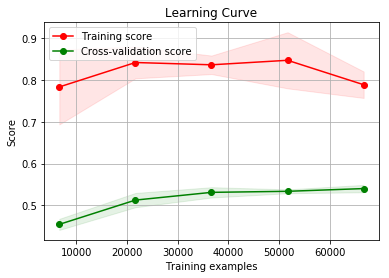

In [60]:
plt.show()